# Comprehensive Analysis of Loan Default Prediction

## 1. Data Exploration and Initial Assessment

### 1.1 Descriptive Statistics

Using the `describe` method, we assess the central tendencies and spread of each variable in the dataset. This includes:

- **Count**: Number of non-null entries for each column.
- **Mean**: The average value of each feature.
- **Standard Deviation (std)**: Measures the dispersion or spread of the data.
- **Minimum (min)**: The smallest value in the dataset.
- **25th Percentile (25%)**: The value below which 25% of the data falls.
- **Median (50%)**: The middle value separating the higher half from the lower half.
- **75th Percentile (75%)**: The value below which 75% of the data falls.
- **Maximum (max)**: The largest value in the dataset.

By examining these statistics, we can identify any potential issues with the data, such as outliers, unusual minimum or maximum values, or large deviations that might affect model performance.



In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ISLP import confusion_table


df = pd.read_csv('../../data/raw/credit_risk_dataset.csv')

df.rename(columns={'cb_person_cred_hist_length': 'person_credit_history'}, inplace=True)
df.rename(columns={'cb_person_default_on_file': 'person_credit_default'}, inplace=True)

df.dropna(inplace=True)

df.drop_duplicates(inplace=True)

df = df[df['person_age'] < 100]

print(df.head())

print(df.describe())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income person_credit_default  person_credit_history  
0                 0.59                     Y                      3  
1                 

In [17]:
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_credit_history']

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade','person_credit_default']



## Data Distribution Insights

These histograms illustrate the distribution of values for each numerical feature, providing insights into their frequency and spread across the dataset.


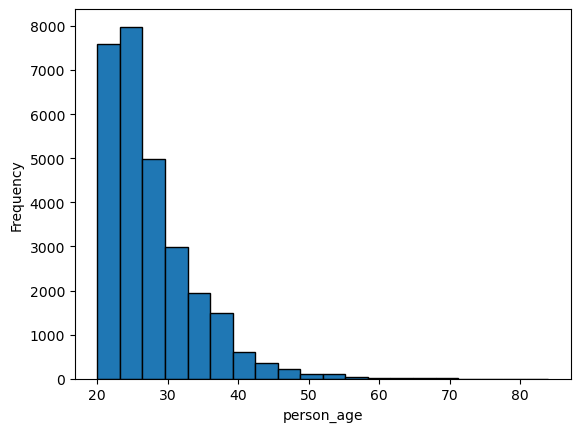

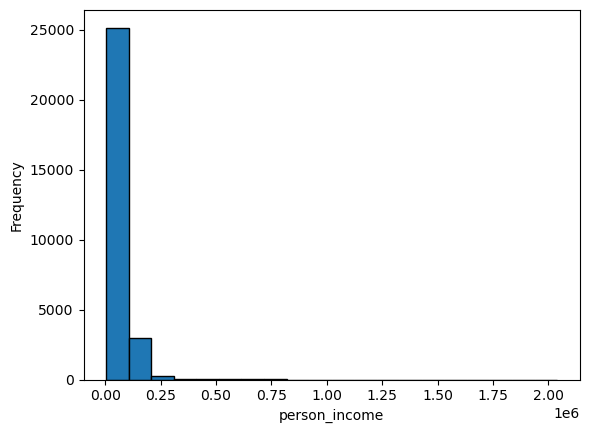

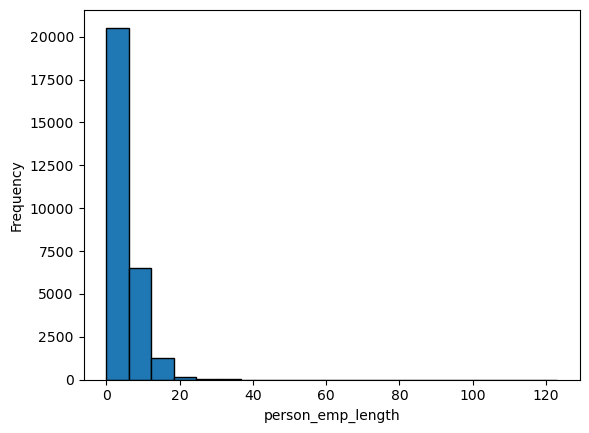

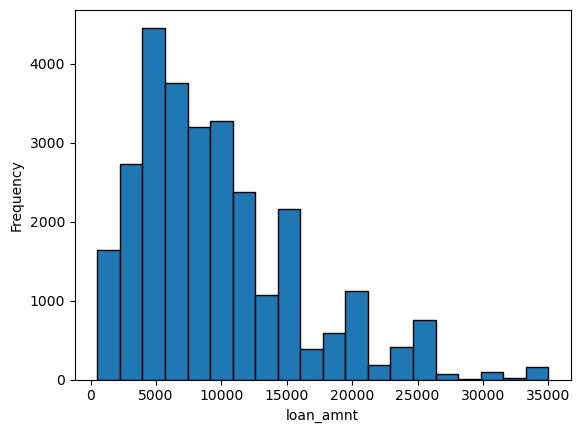

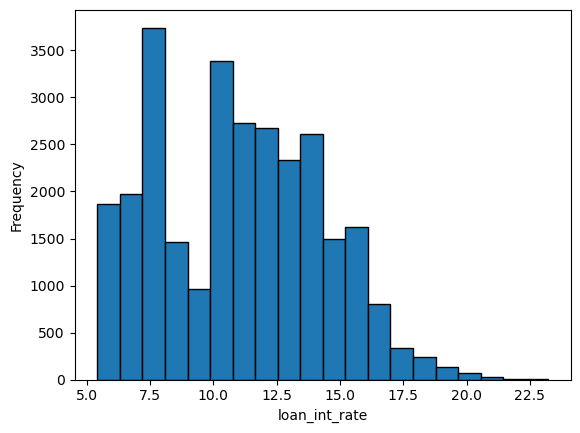

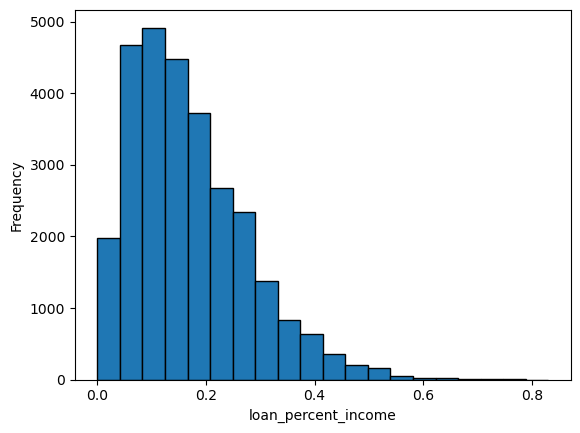

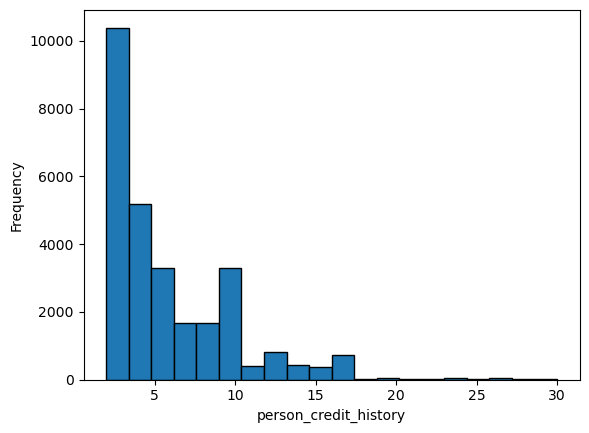

In [18]:
for feature in numeric_features:
    plt.hist(df[feature], bins=20, edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


## Handling Outliers

In analyzing our dataset, we encountered potential outliers across several key features such as age and interest rates. It's crucial to recognize that outliers often represent genuine data points reflecting extreme but plausible scenarios. Removing outliers without careful consideration can introduce bias and undermine the model's ability to generalize to diverse real-world situations. Therefore, we opted to retain these outliers to ensure our model remains robust and can handle a wide range of conditions.Additionally, during the preprocessing phase, records with an age greater than 100 were noticed and filtered out to maintain data integrity.


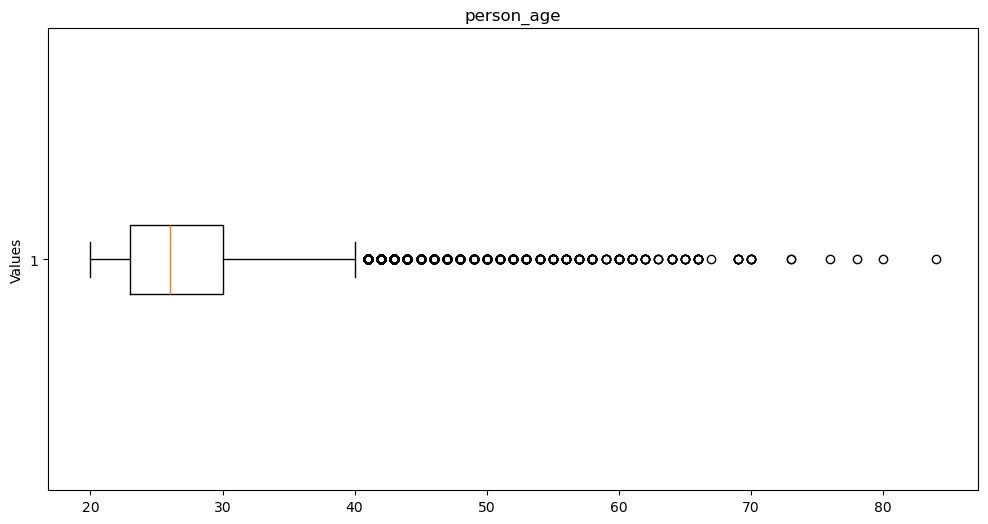

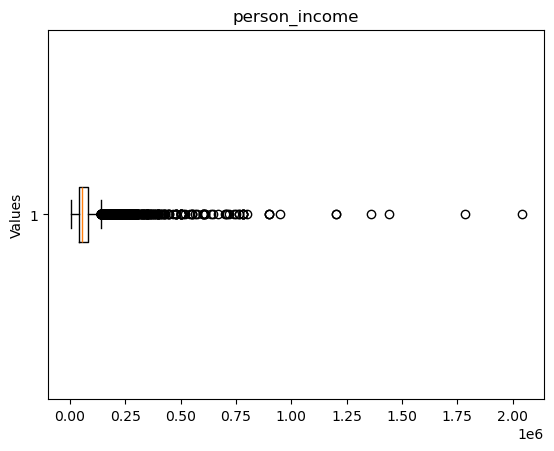

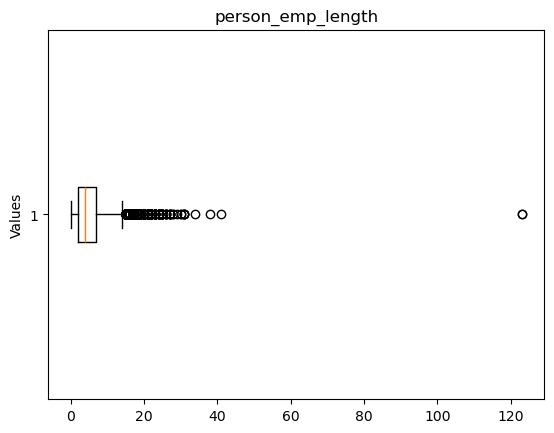

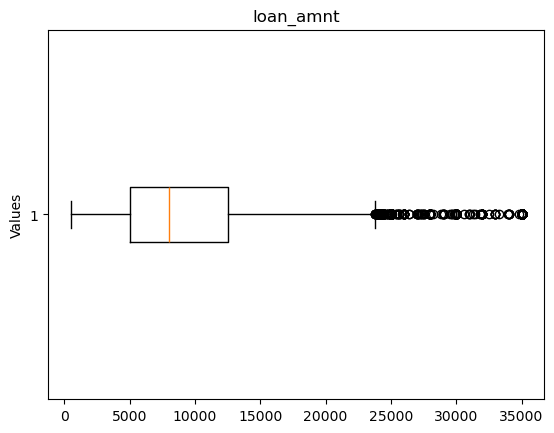

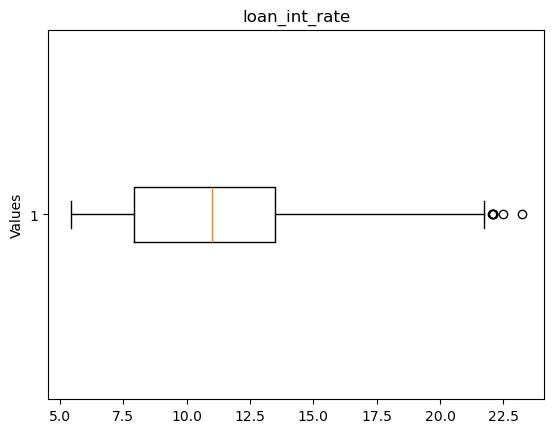

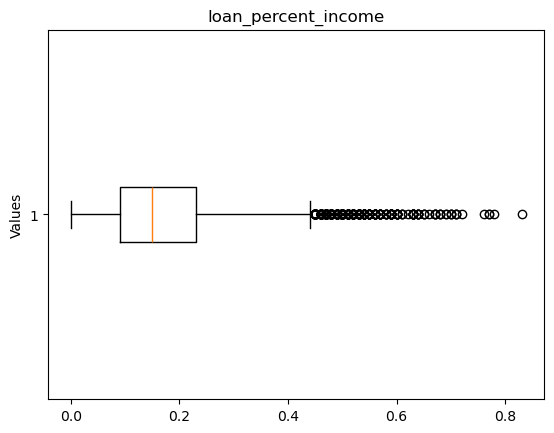

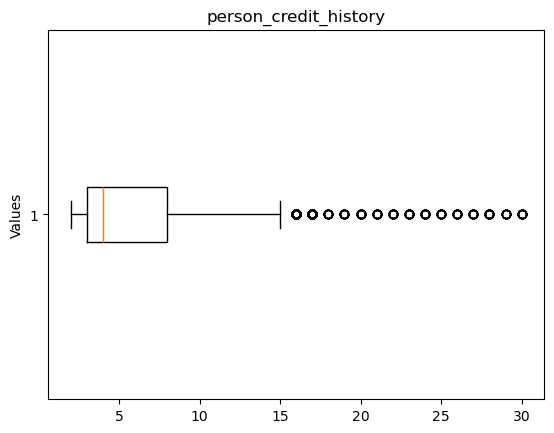

In [19]:
plt.figure(figsize=(12, 6))

for feature in numeric_features:
    plt.boxplot(df[feature],vert=False)
    plt.title(feature)
    plt.ylabel('Values')
    plt.show()



## Analysis of Loan Status Across Numerical Features

From the histograms depicting the distribution of 'loan_amnt', 'loan_int_rate', 'loan_percent_income', a notable trend emerges: as the loan amount increases, the proportion of defaults (depicted by the yellow line) also rises, eventually converging with the non-defaults (blue line) at higher values. This convergence suggests that loan amount may indeed influence default status significantly. Conversely, for features where the lines remain parallel or do not show clear convergence or divergence across different values, such as age, these factors may not exert a significant influence on default probability.

Moreover, the histograms suggest that loan interest rate, loan amount, and loan percentage of income exhibit distinct distributions between default and non-default cases. The pronounced shifts in these features' distributions imply they could be pivotal in predicting default probability, highlighting their potential as key contributors in the model.

This visual exploration underscores the importance of these variables in understanding and predicting loan defaults, suggesting avenues for further investigation and model refinement.


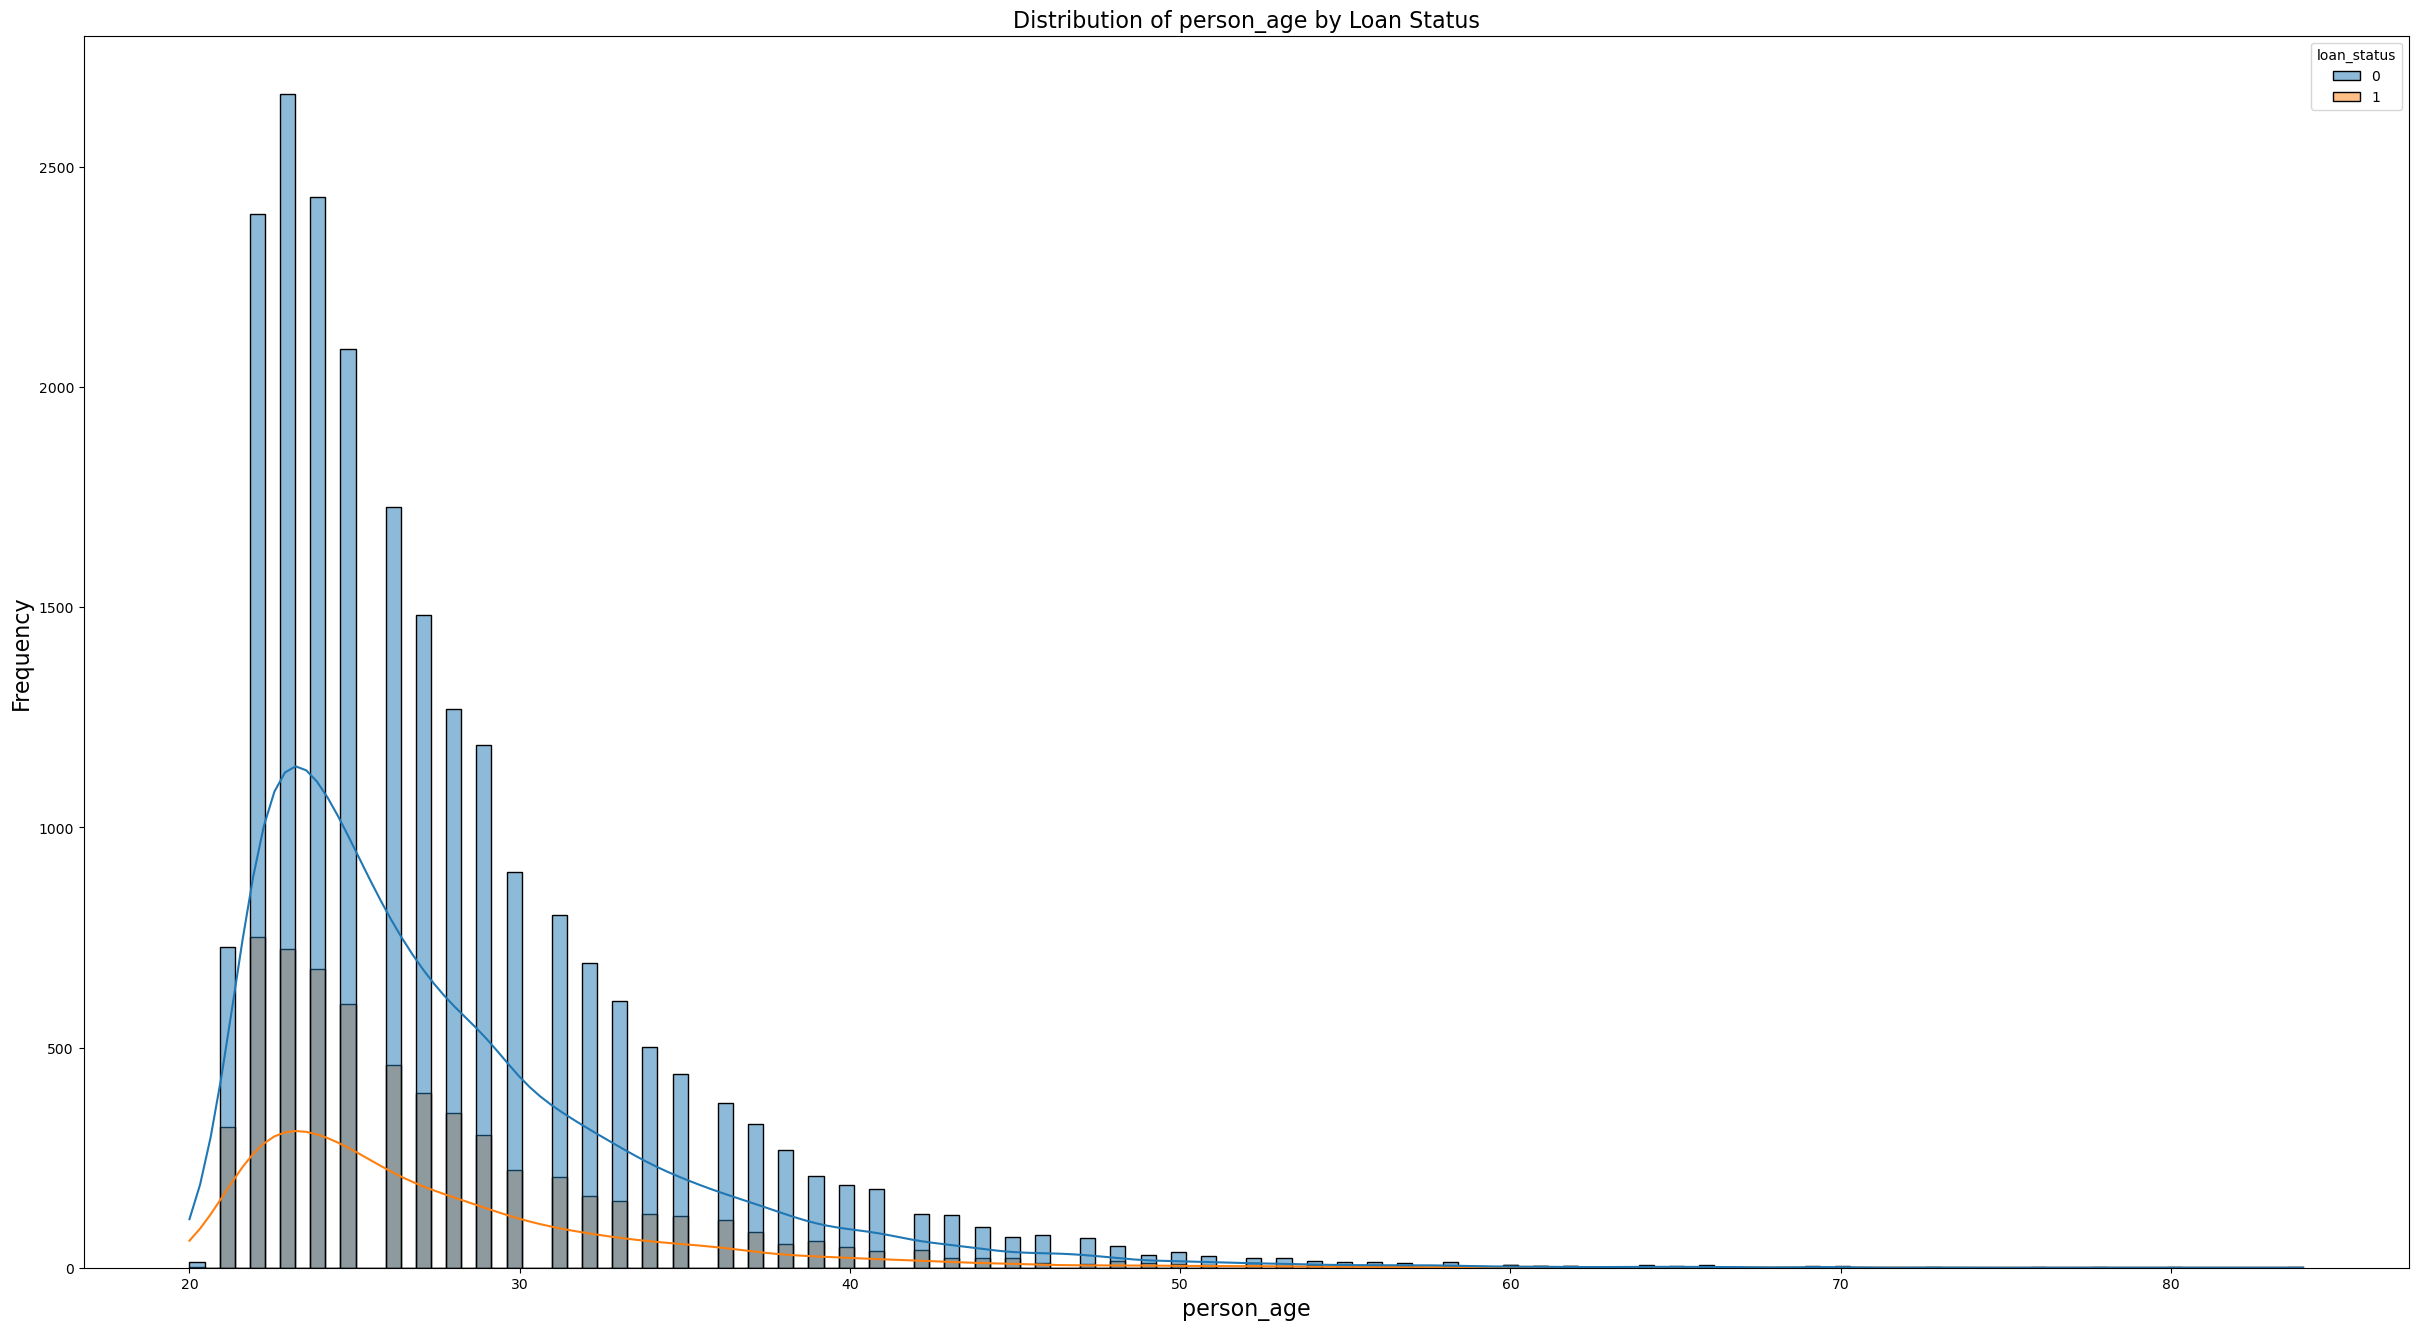

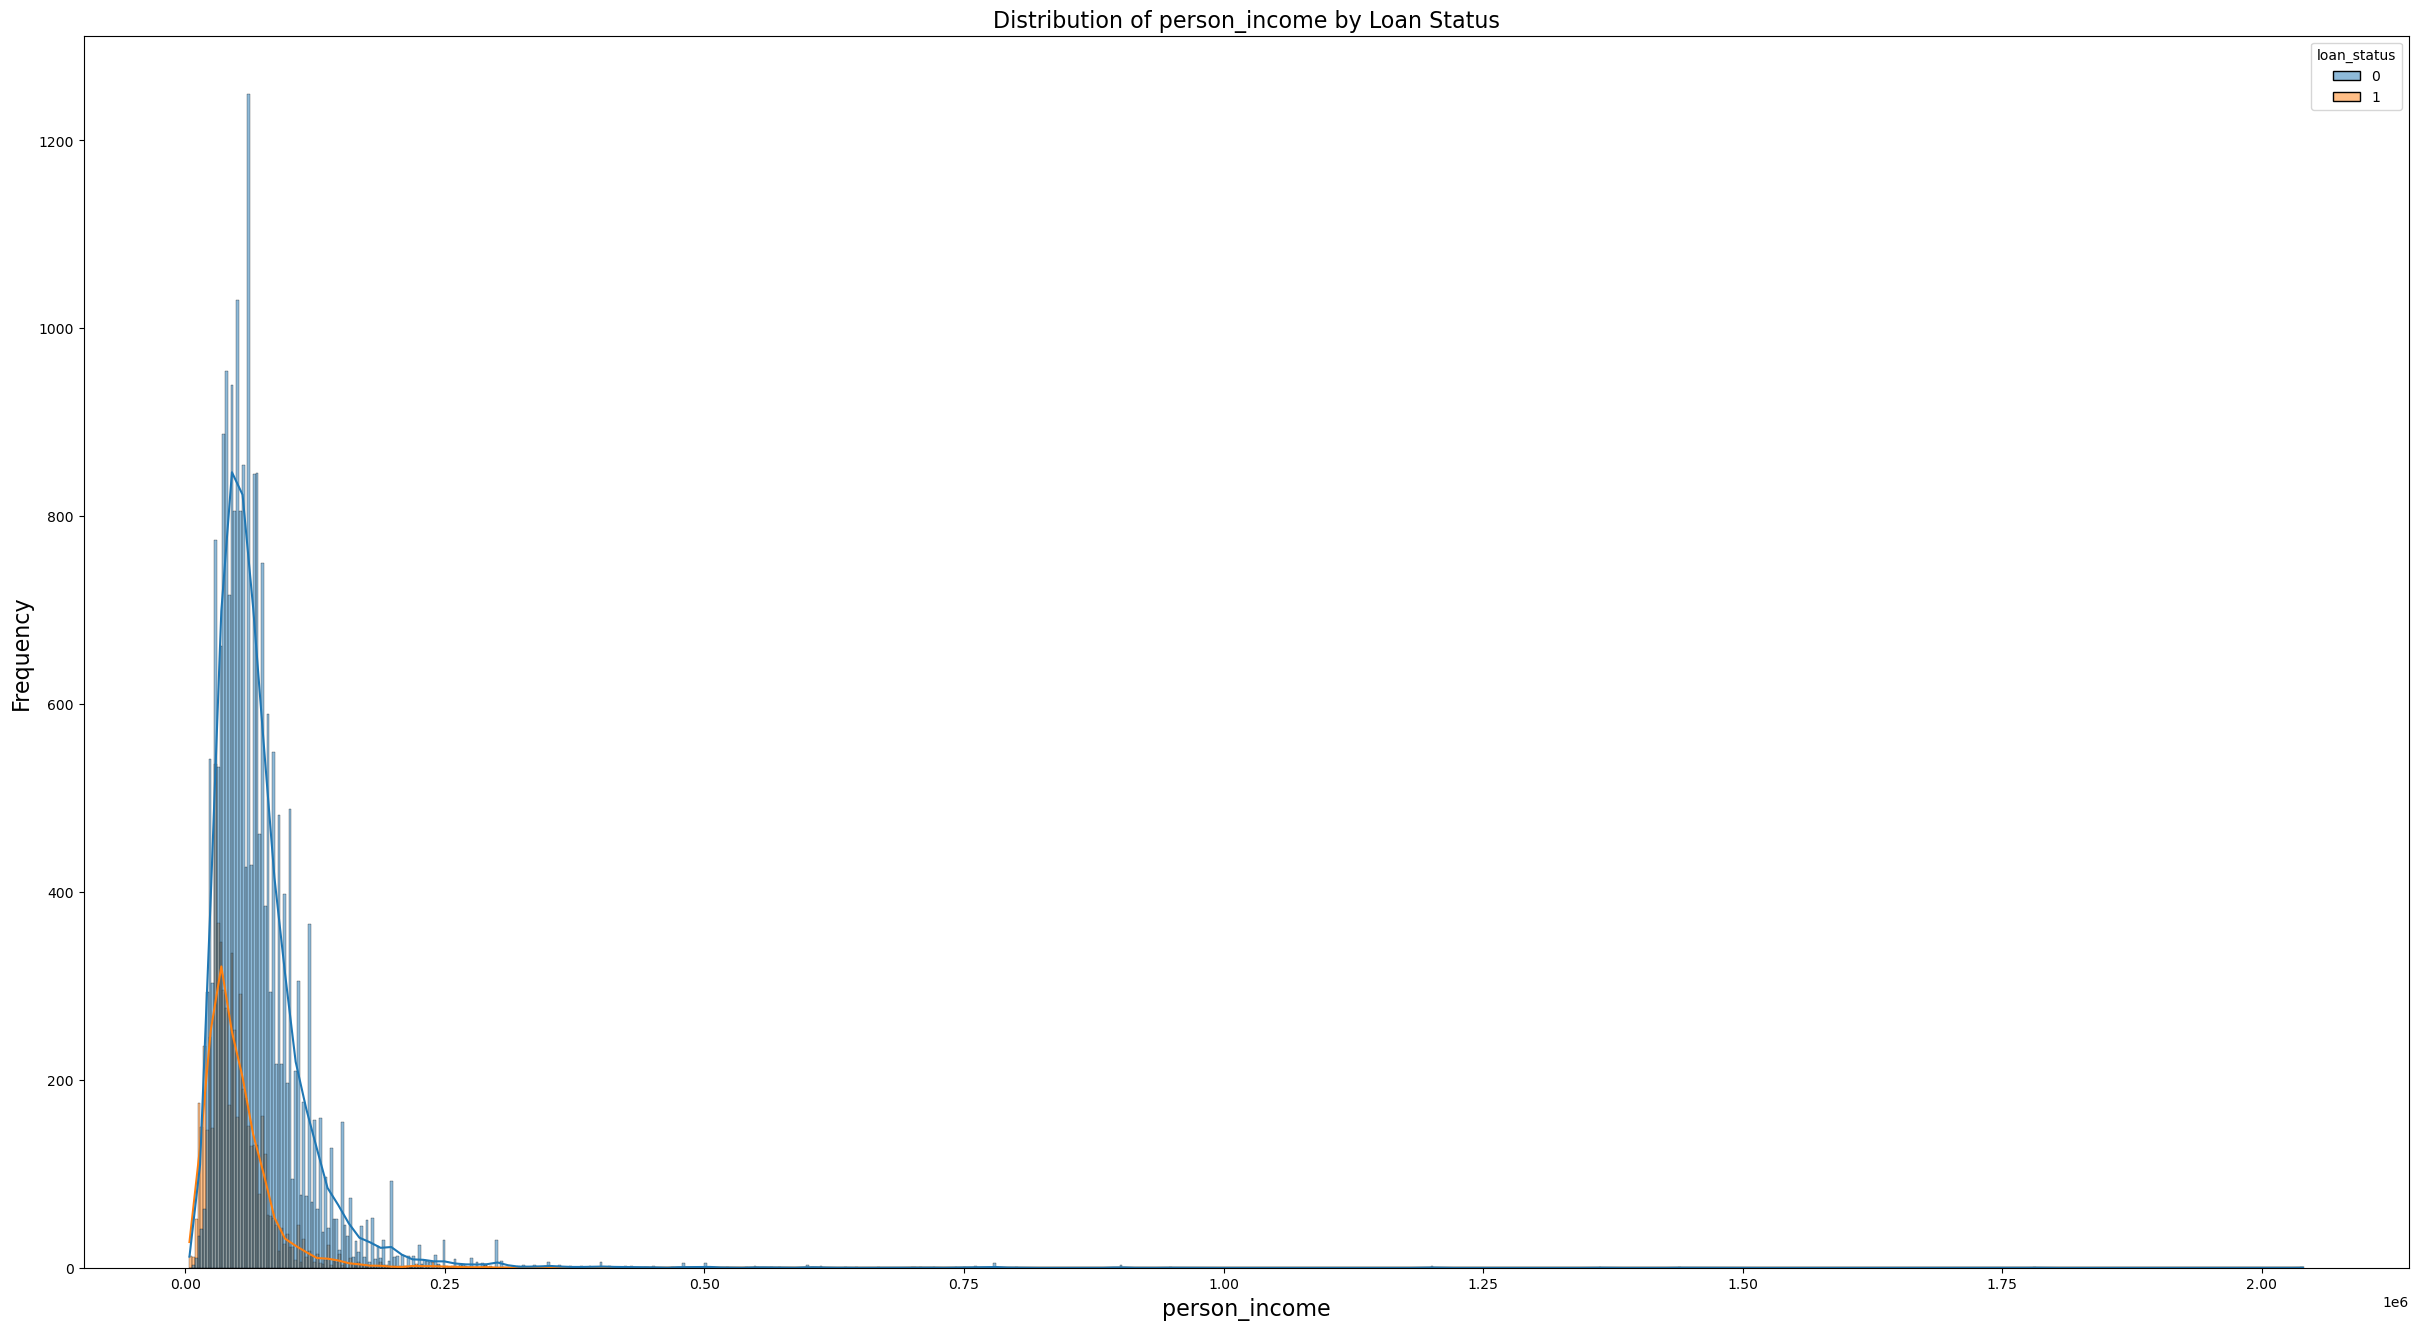

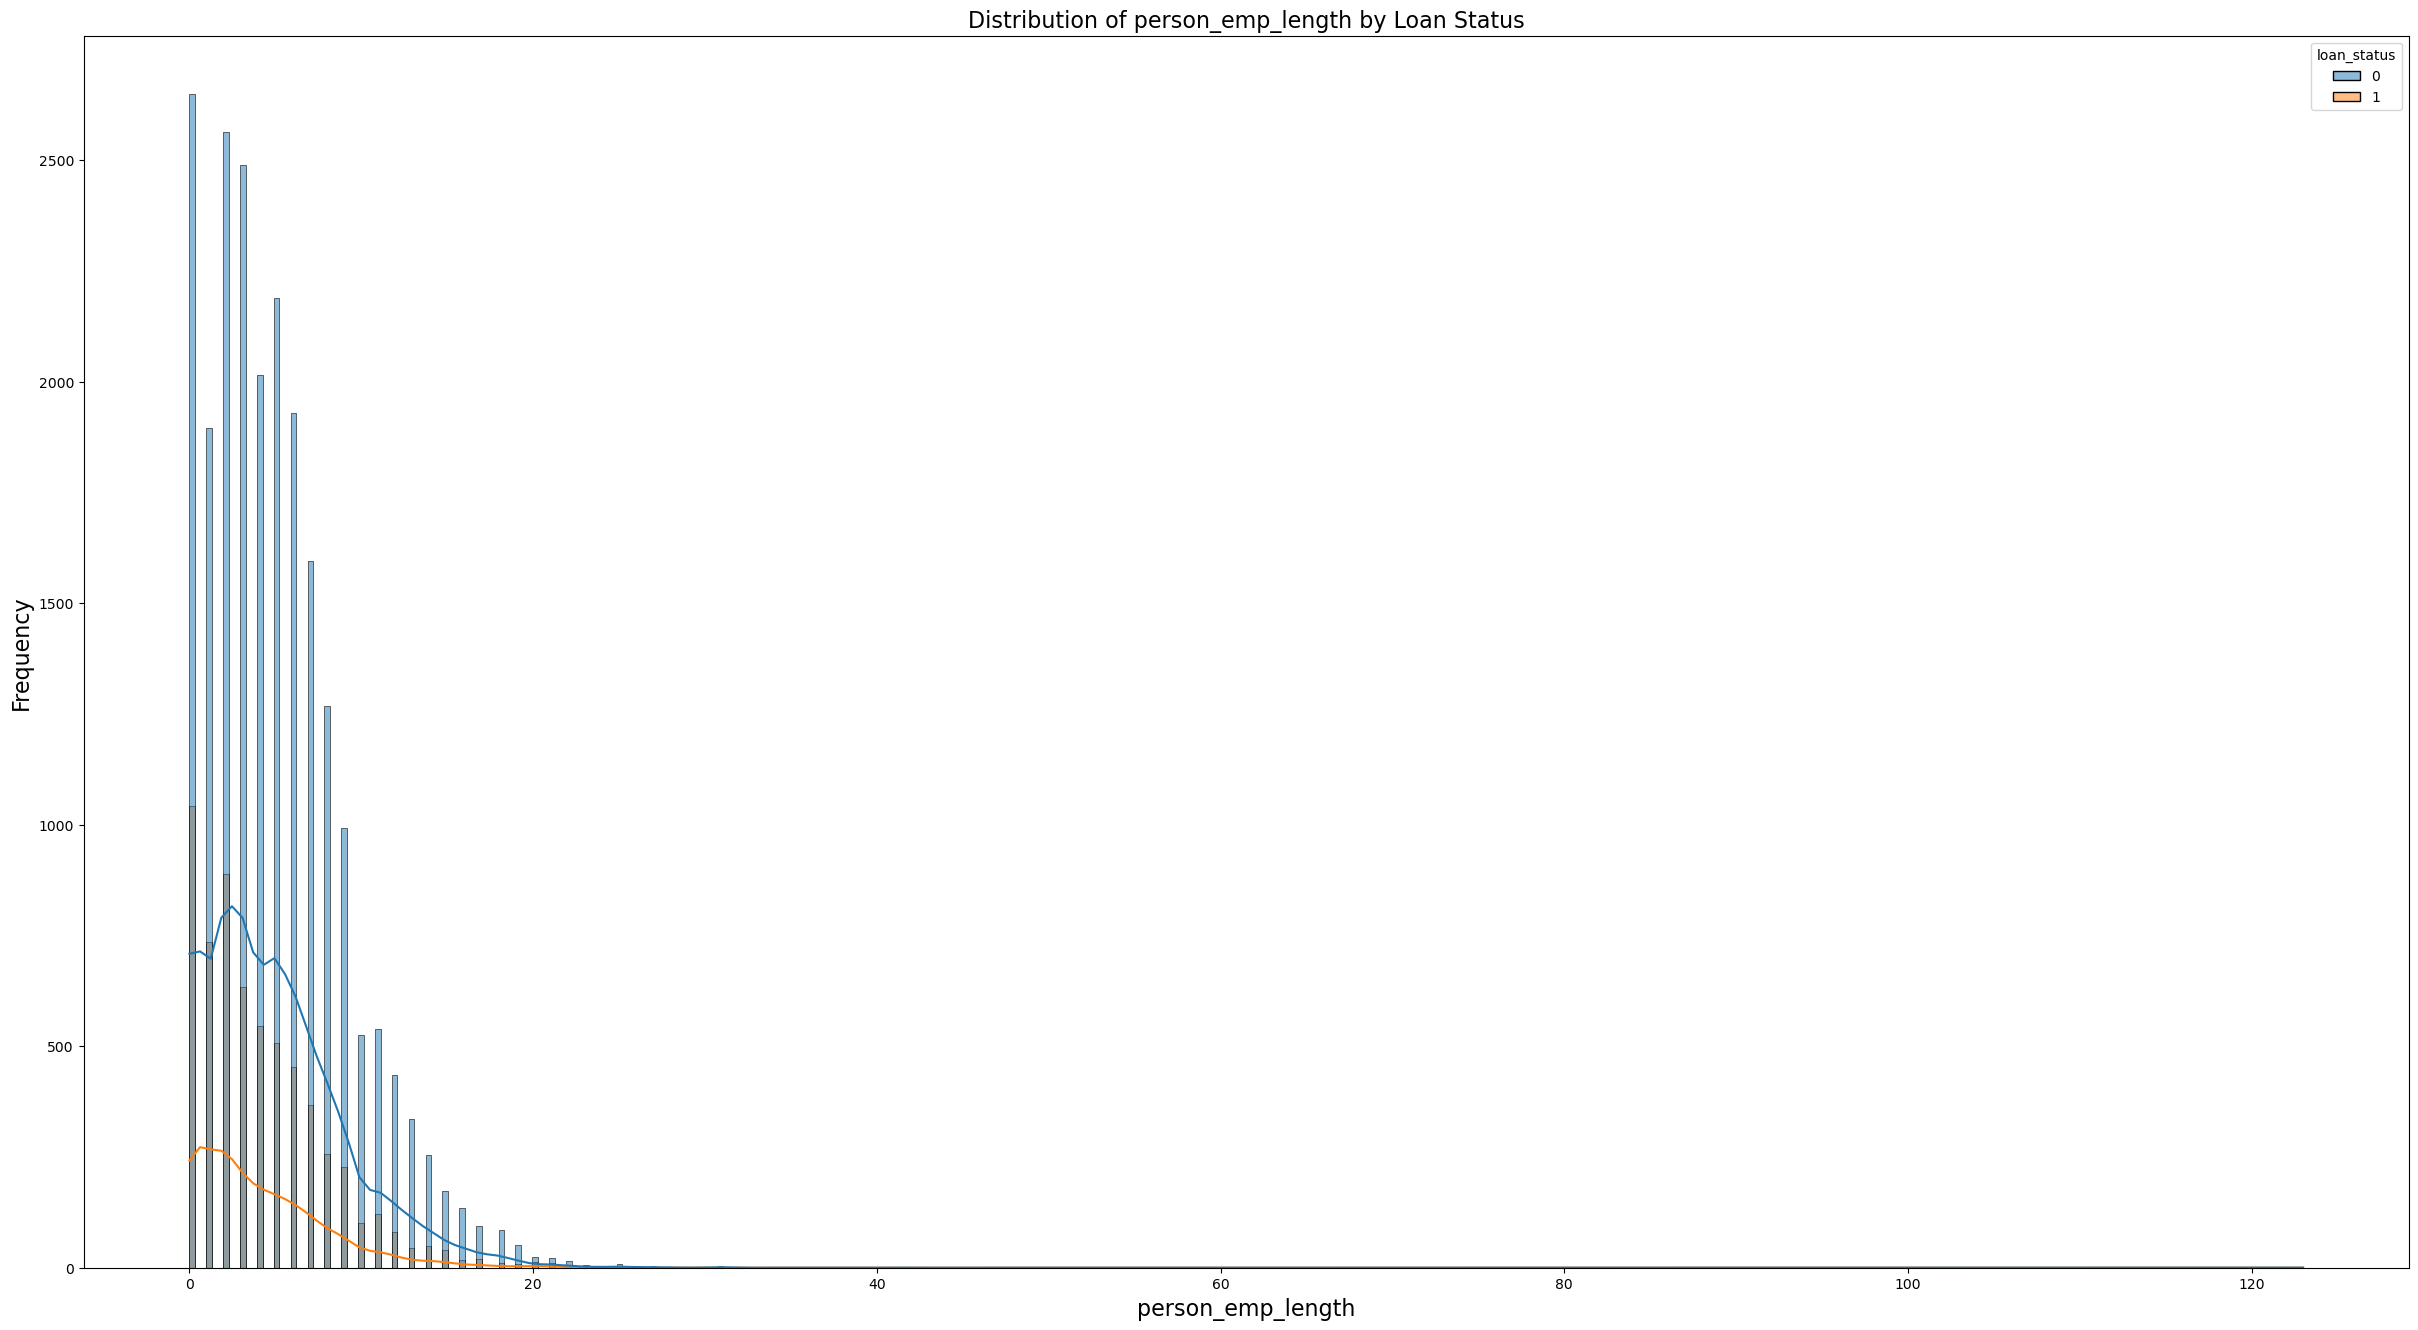

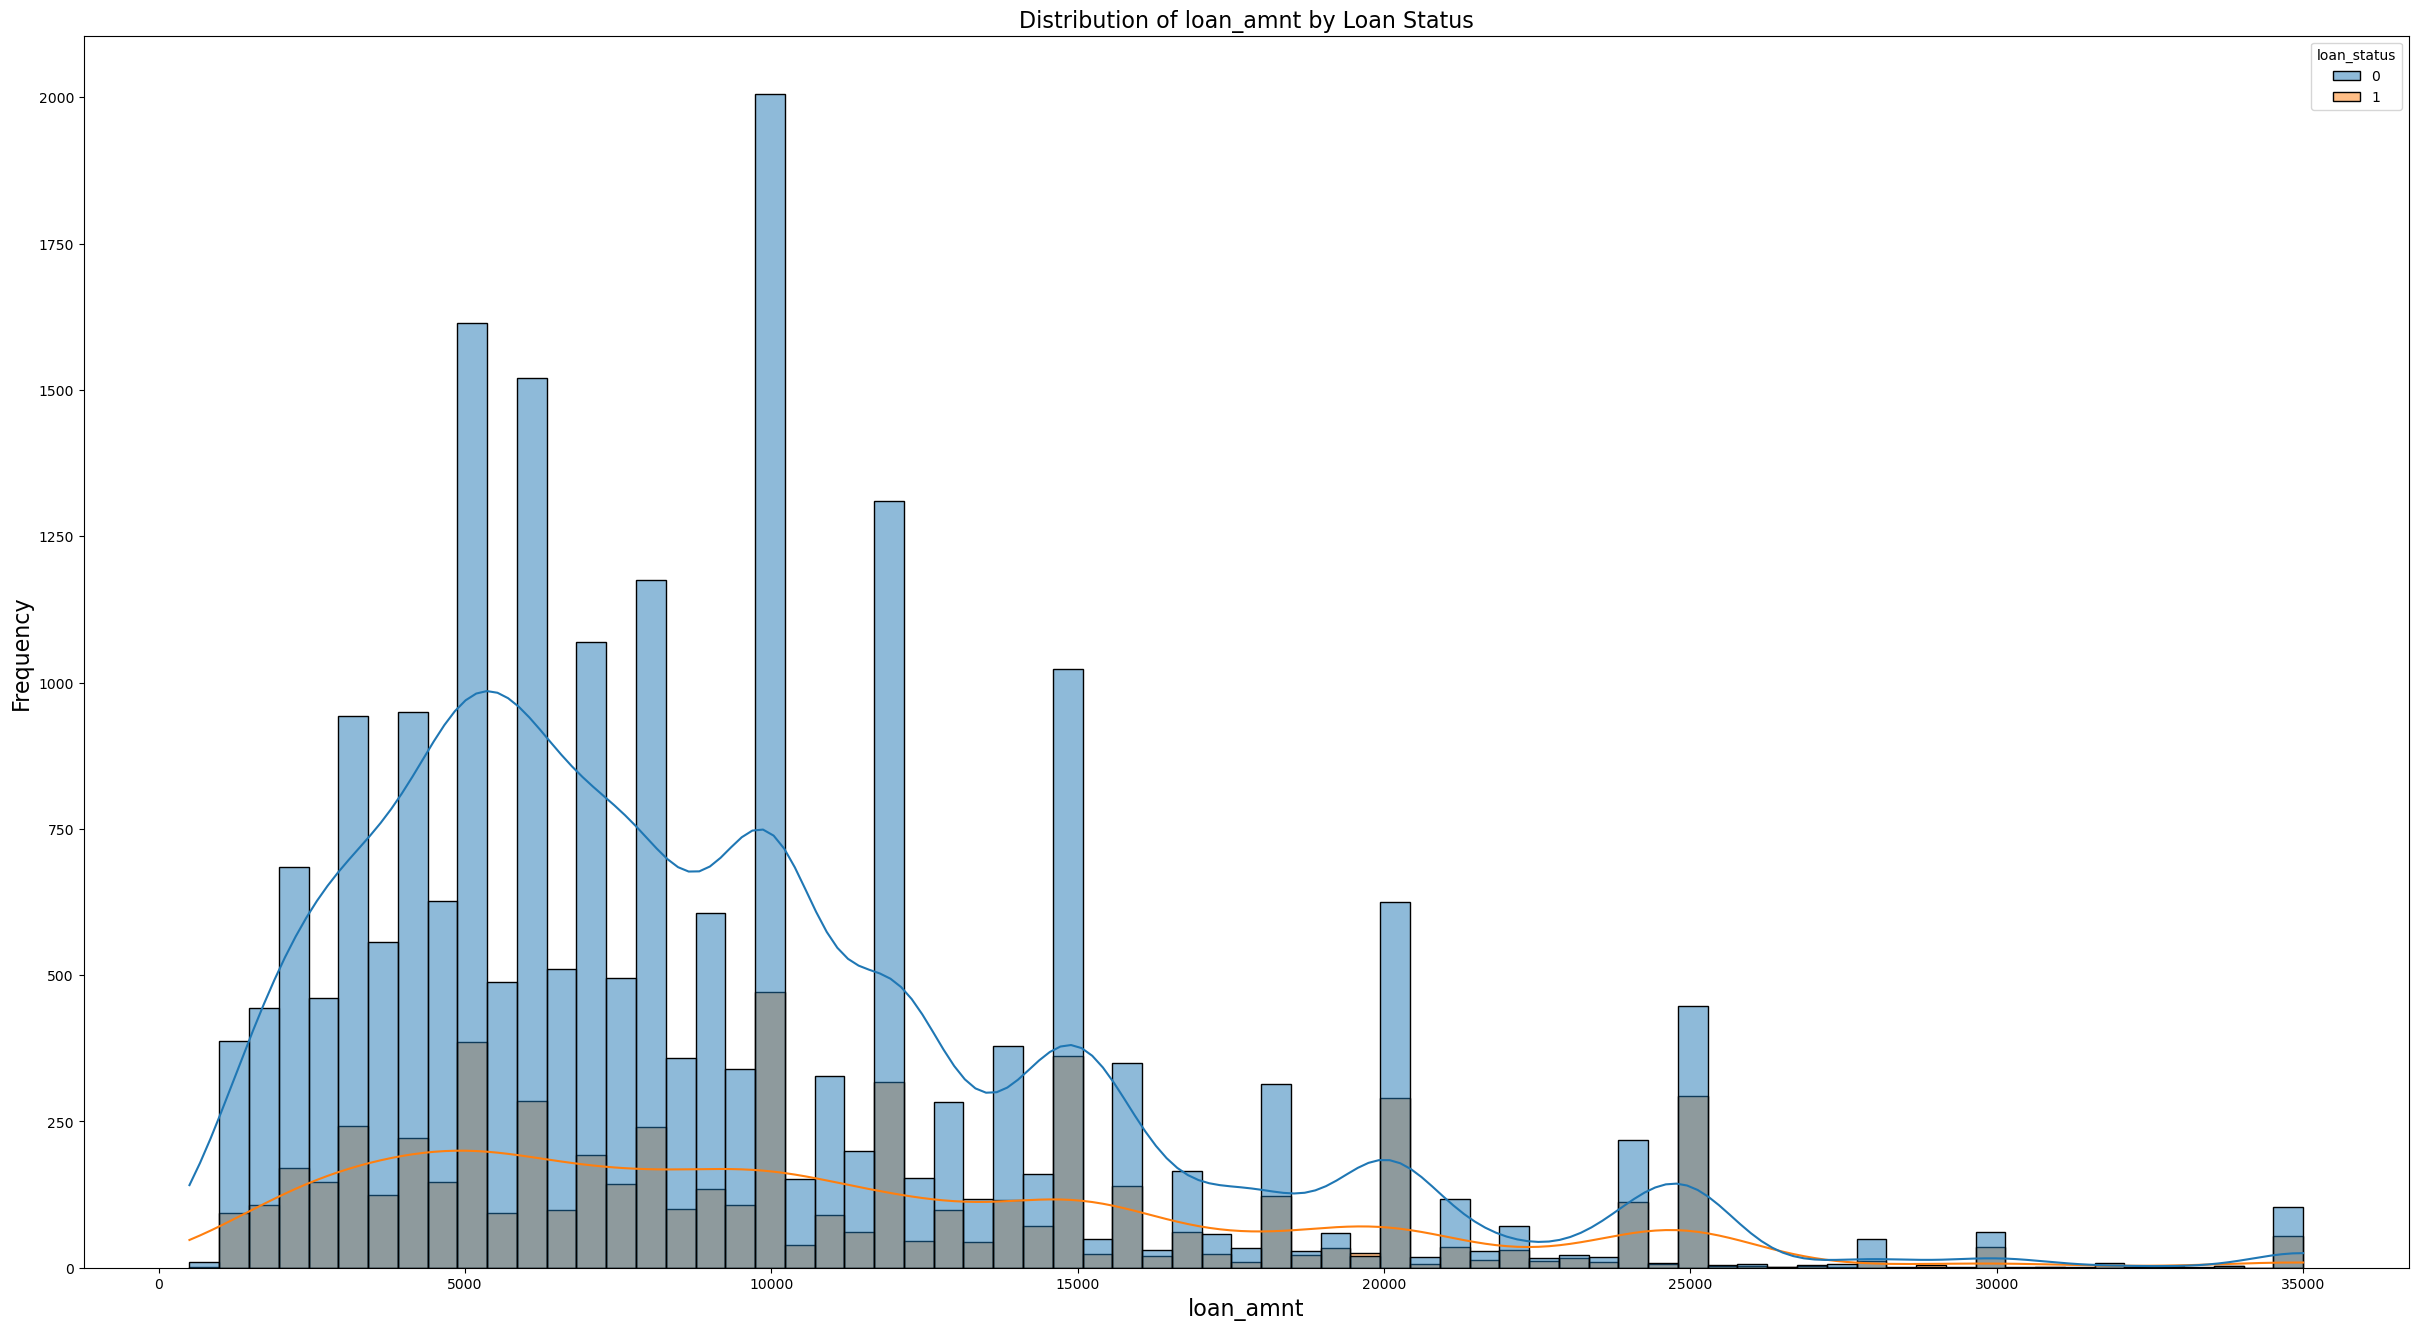

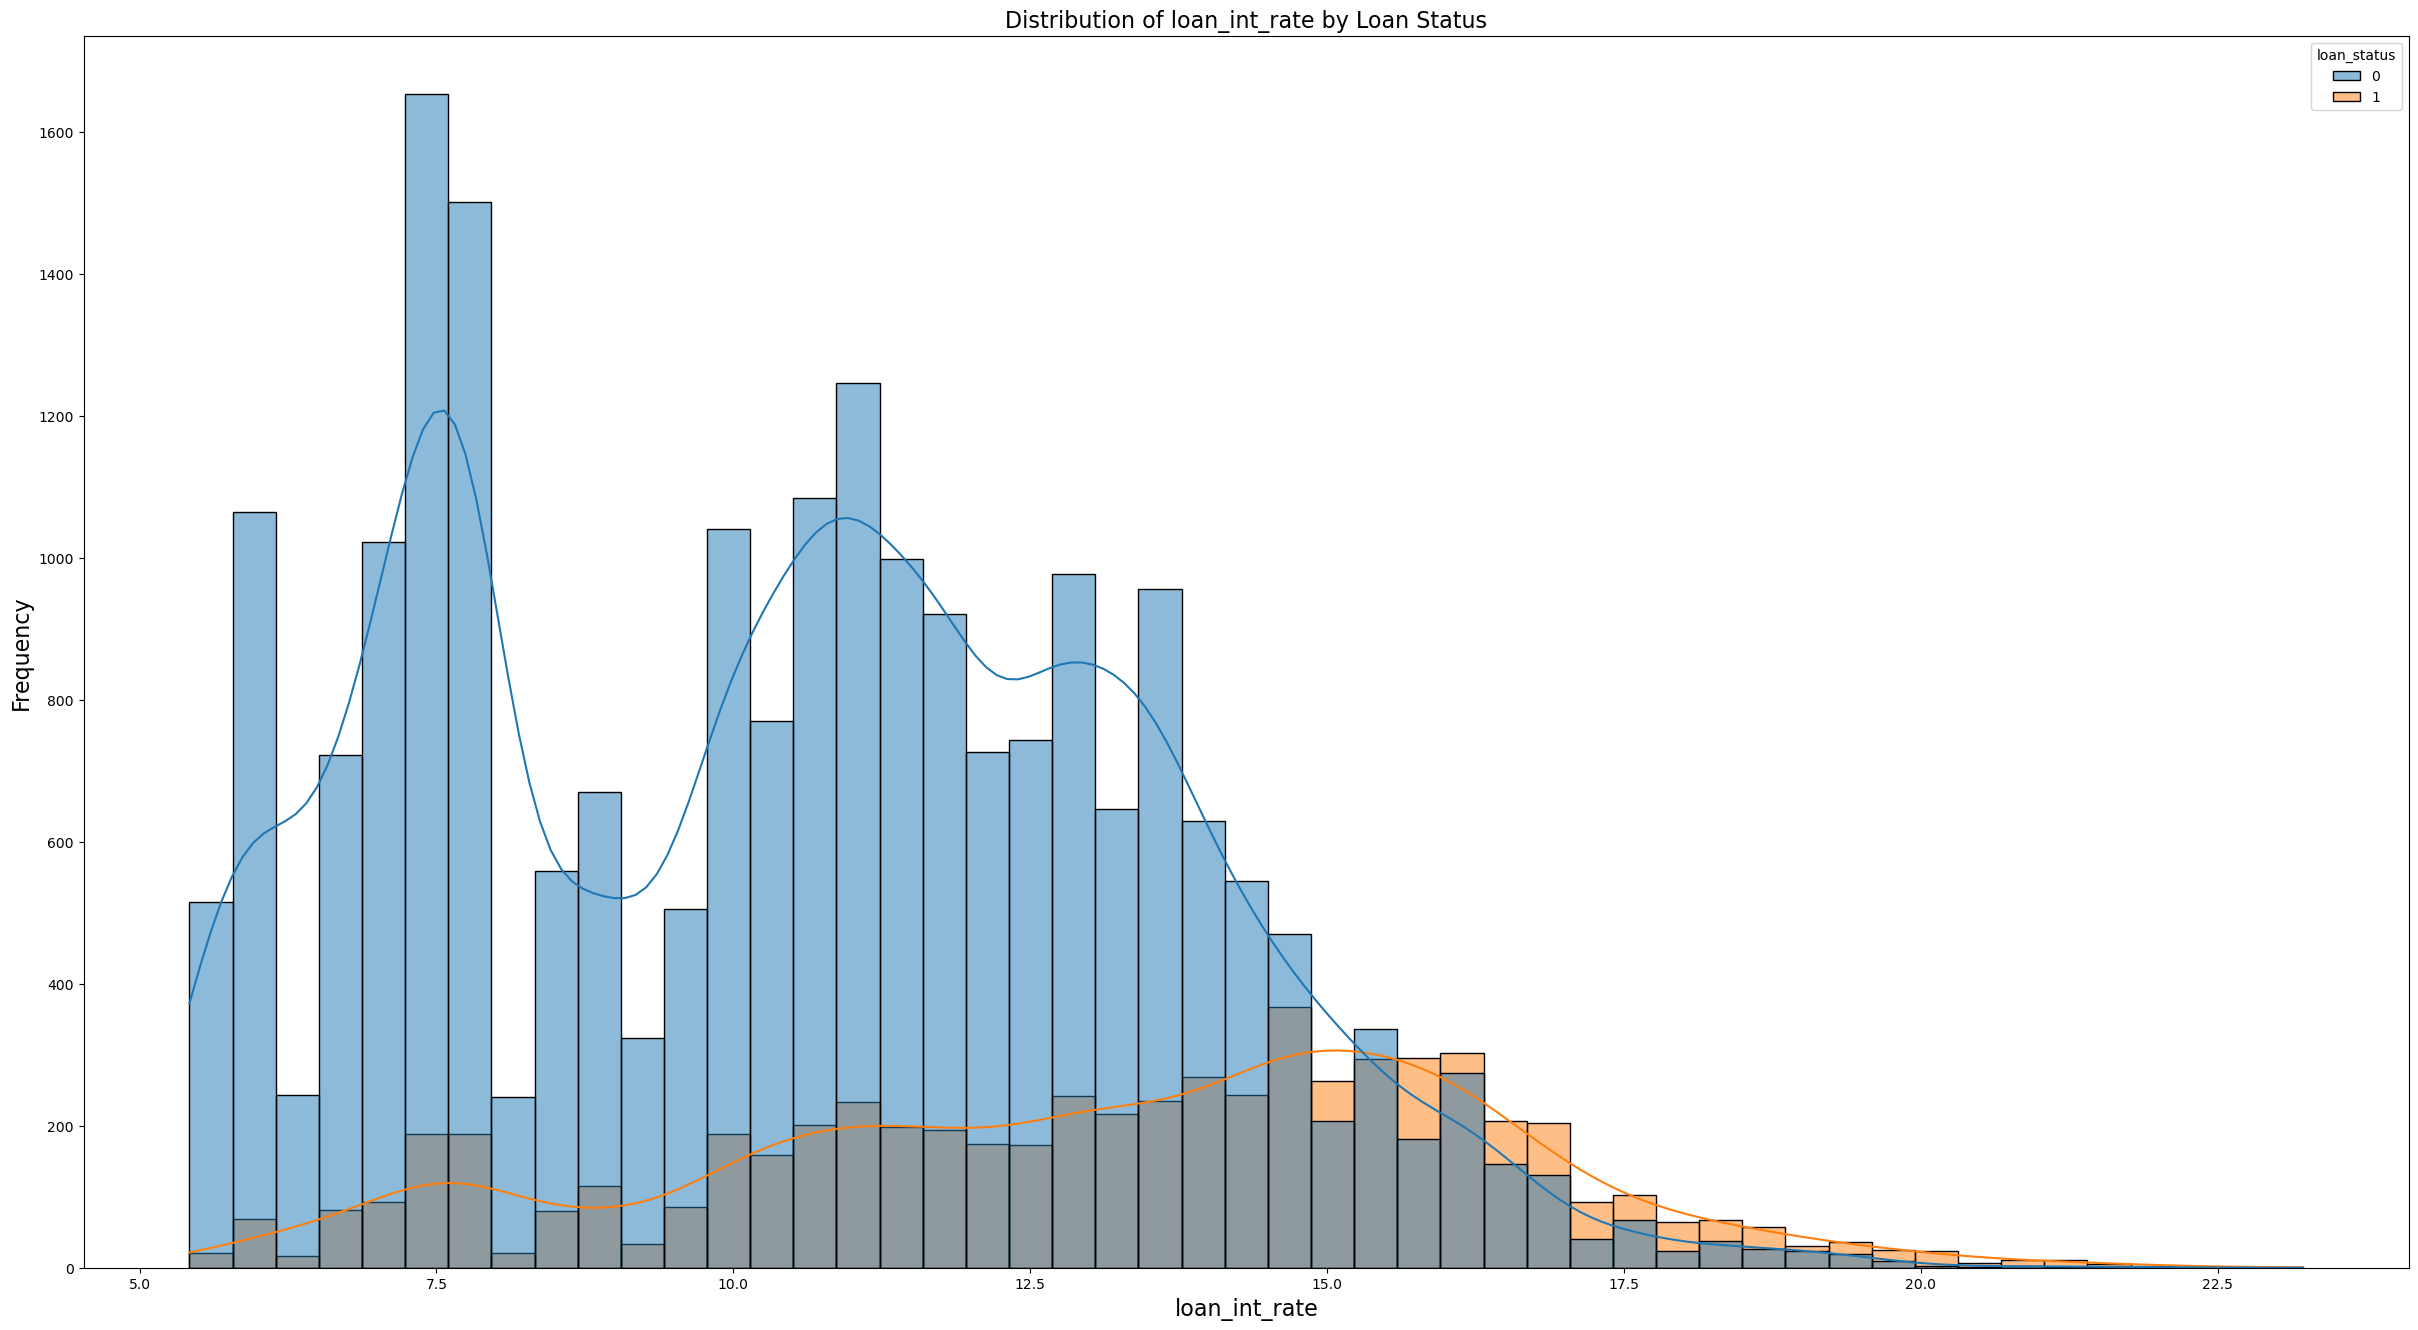

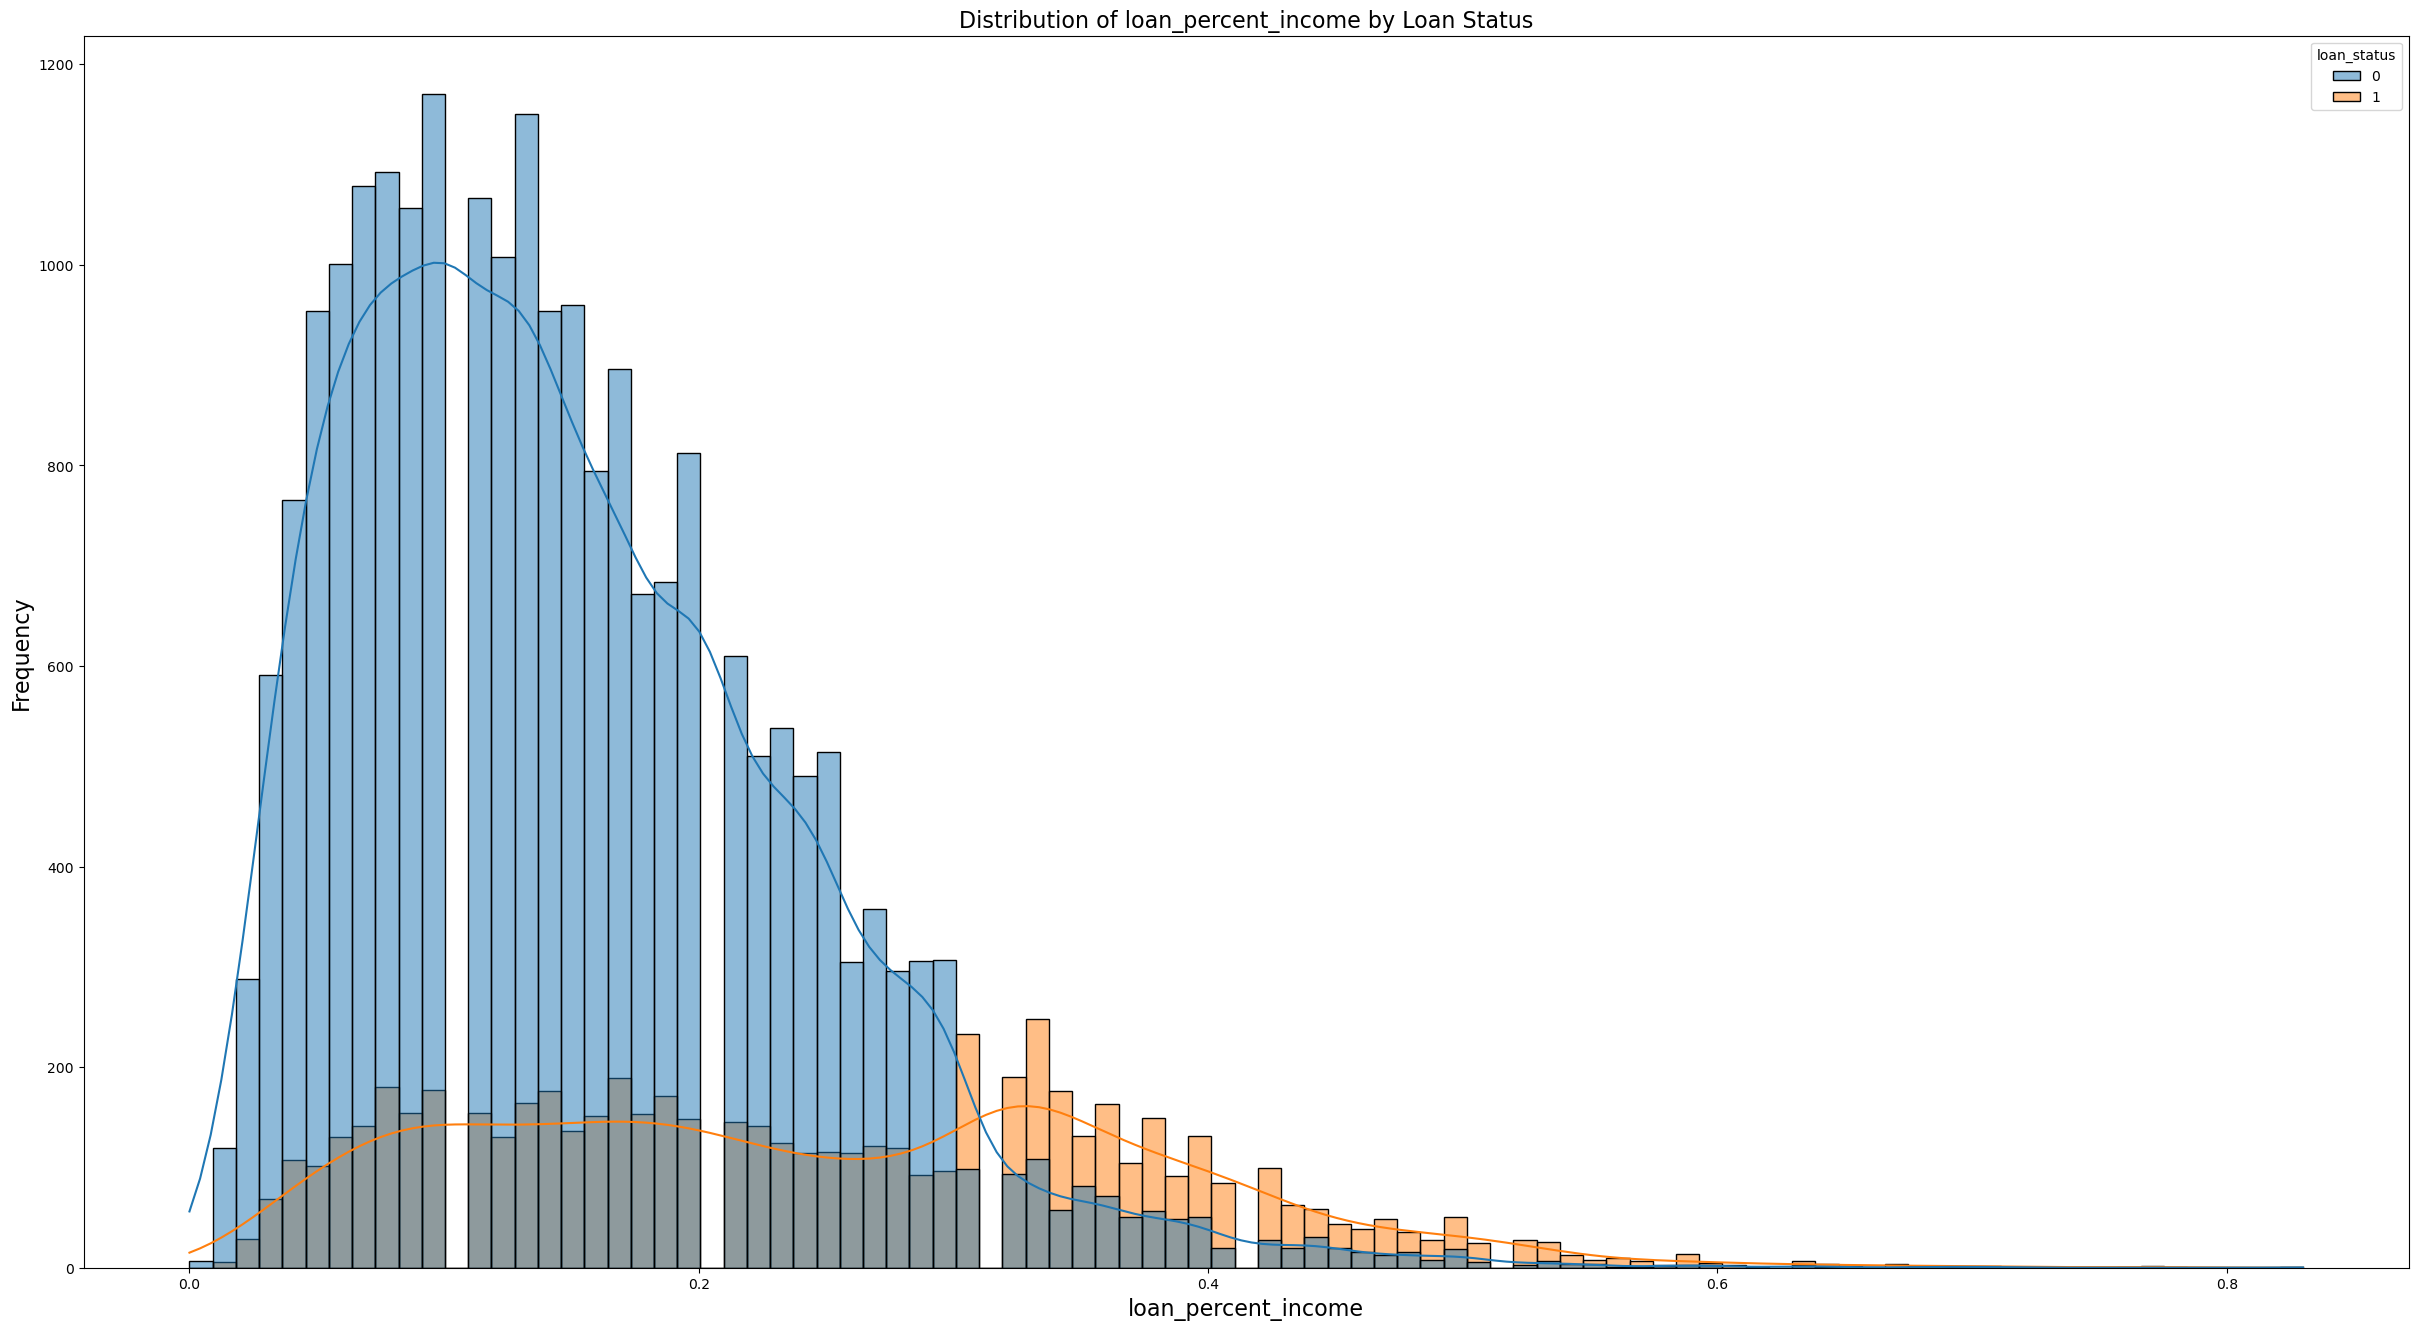

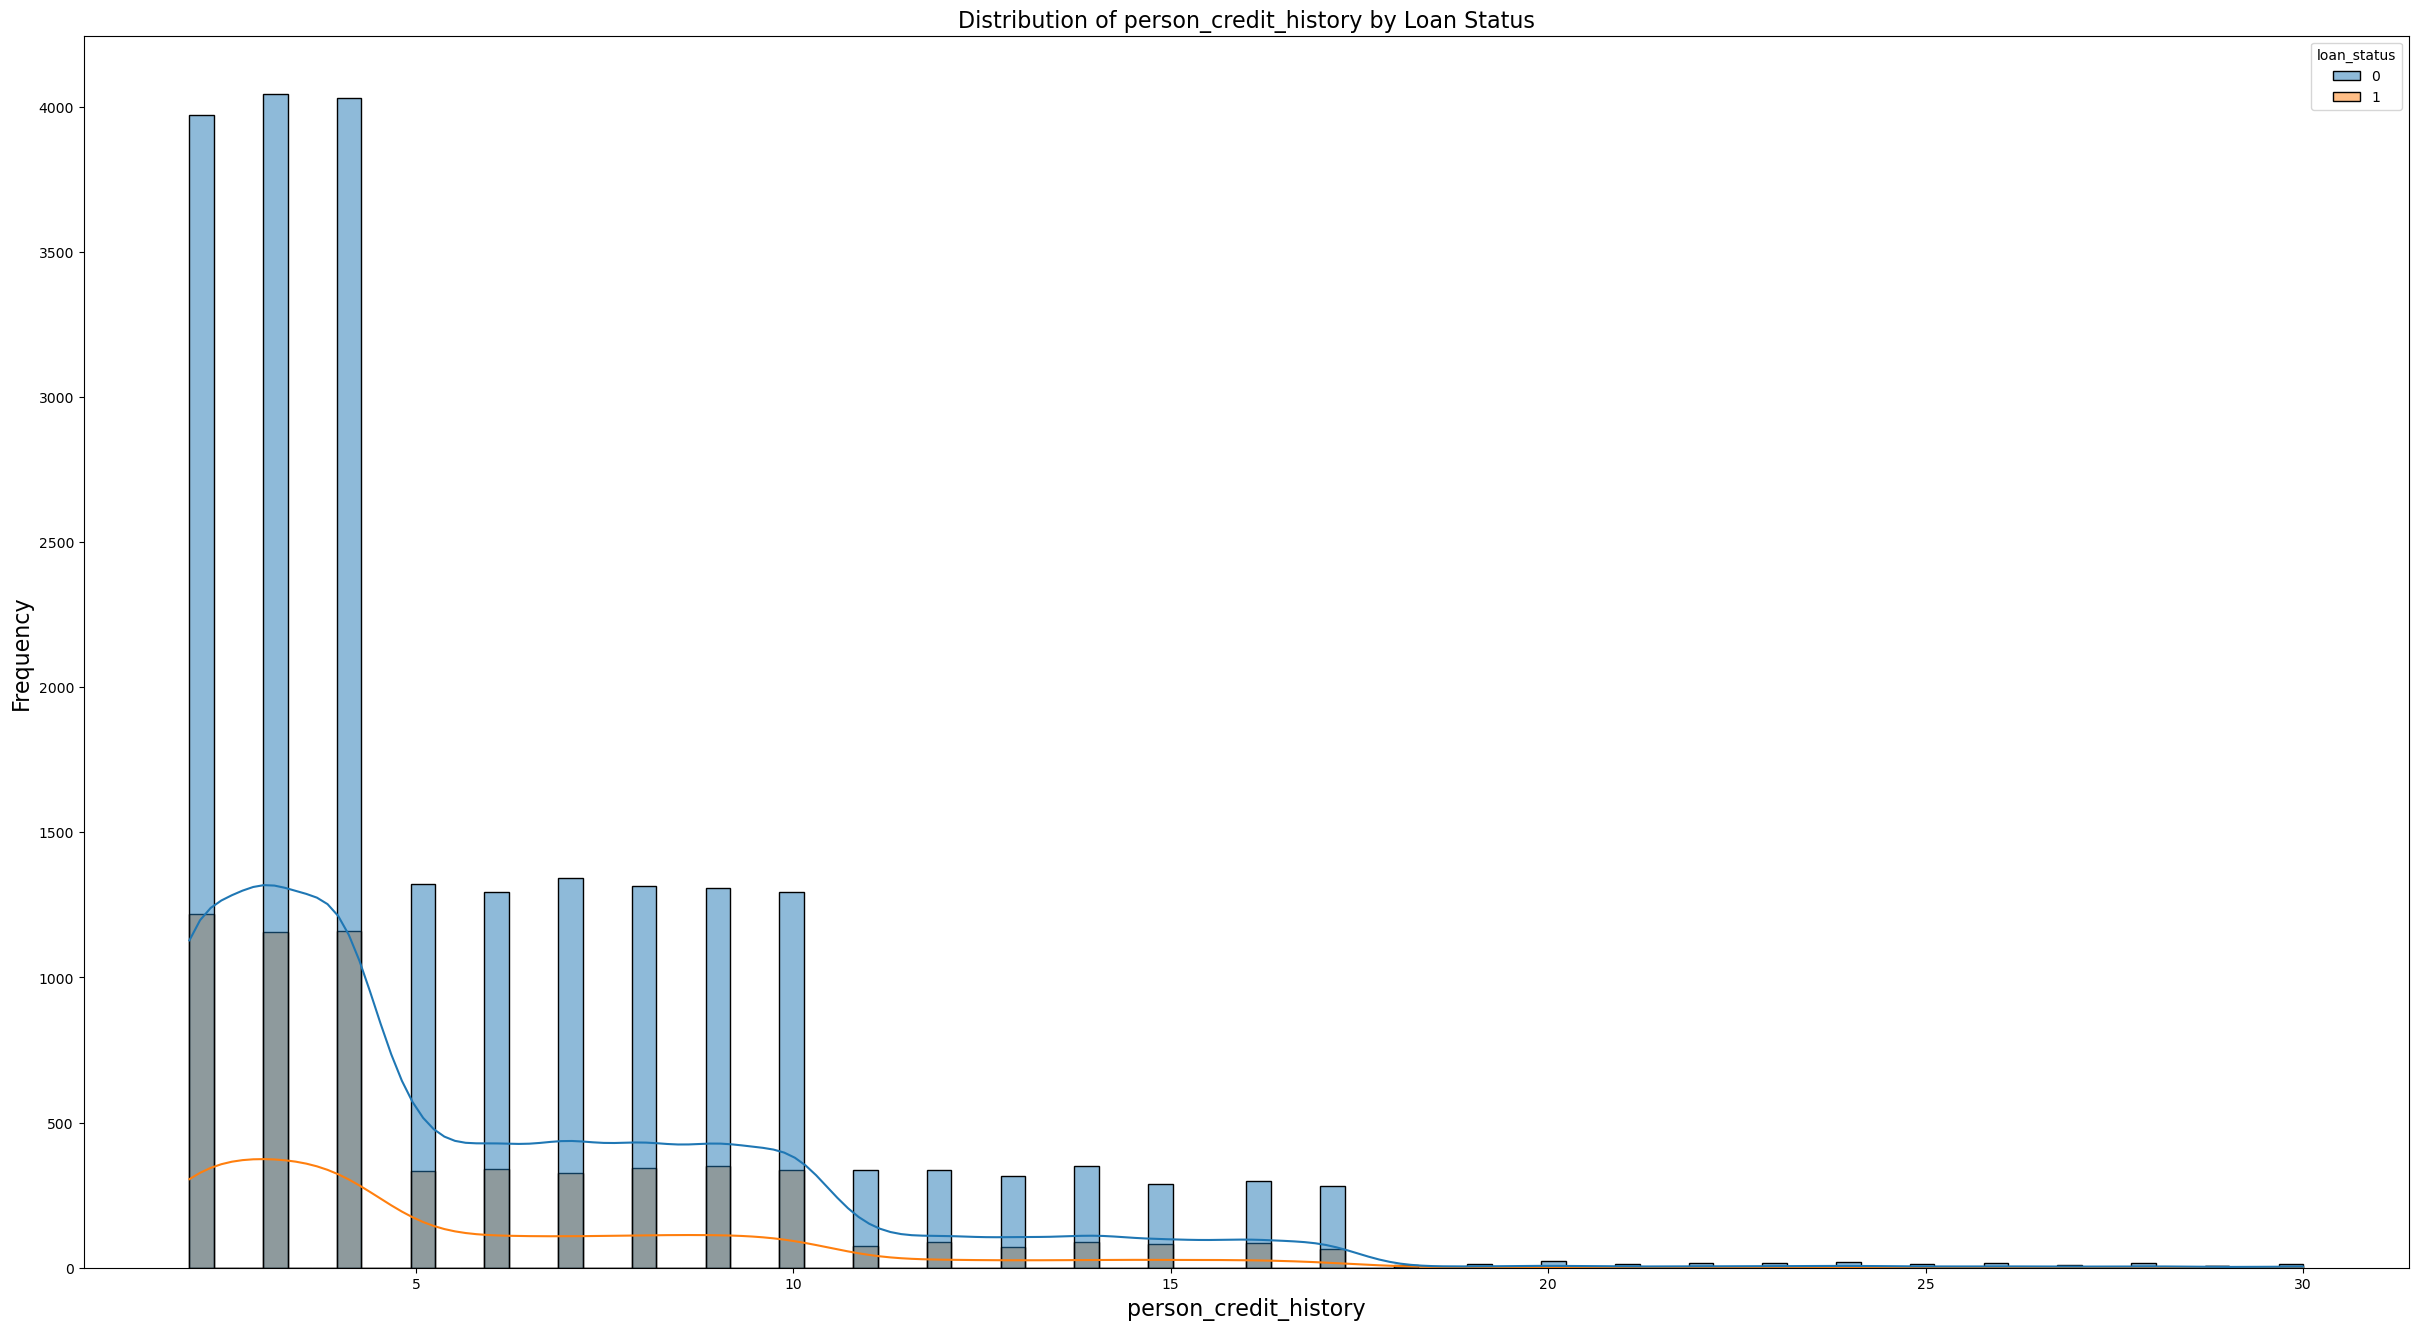

In [20]:
for feature in numeric_features:
    plt.figure(figsize=(30, 16))
    sns.histplot(data=df, x=feature, hue='loan_status', kde=True)
    plt.title(f'Distribution of {feature} by Loan Status', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()



## Analysis of Loan Status Across Categorical Features

The count plots illustrating loan status across categorical features reveal notable insights into their impact on loan default probability. Among these features, loan grade stands out prominently, displaying distinct variations in default rates across different grade categories. Specifically, higher loan grades exhibit lower default frequencies, indicating a strong negative correlation between grade and default probability. Conversely, while other categorical features such as home ownership type and loan intent also demonstrate varying default rates, their impact appears comparatively less pronounced than that of loan grade. This observation underscores the significance of including loan grade as a critical predictor in our model, suggesting it plays a pivotal role in predicting and understanding loan default behavior.


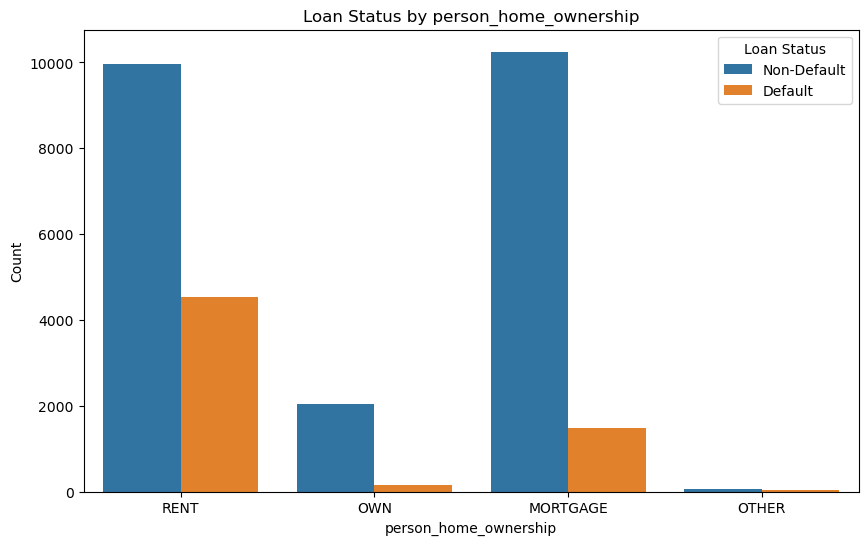

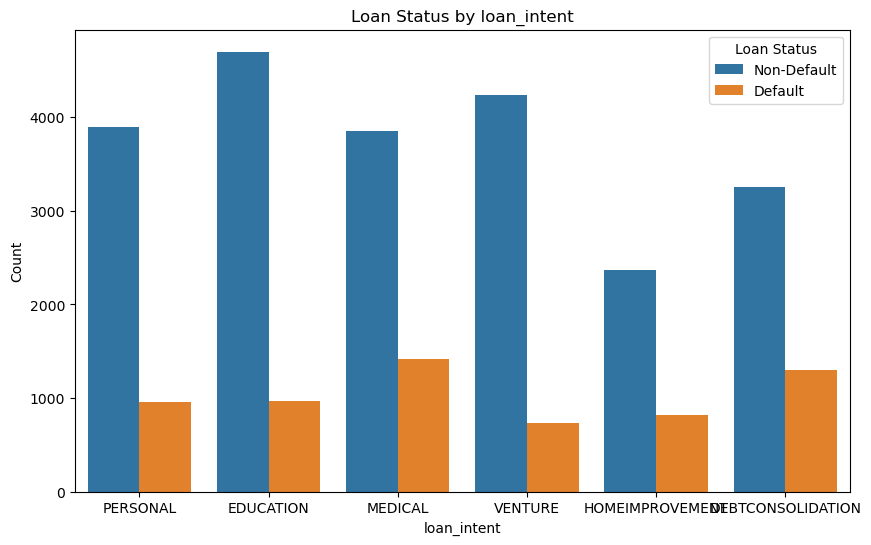

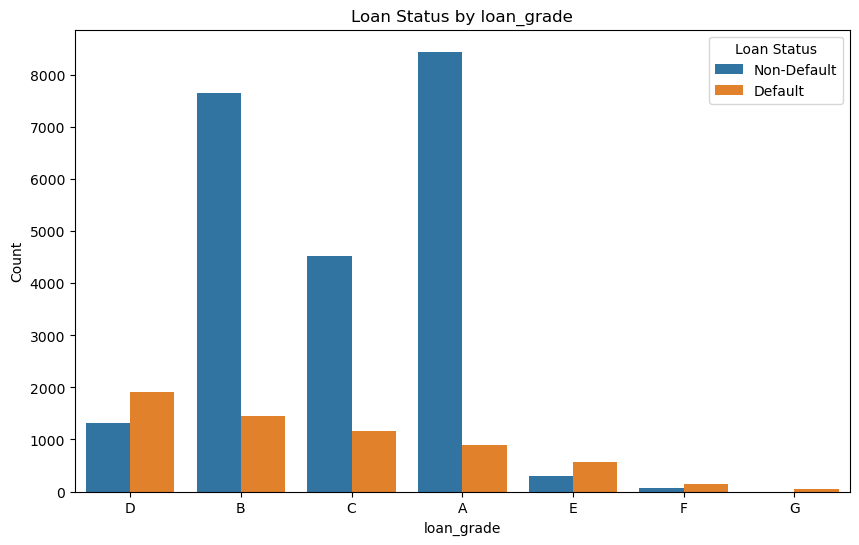

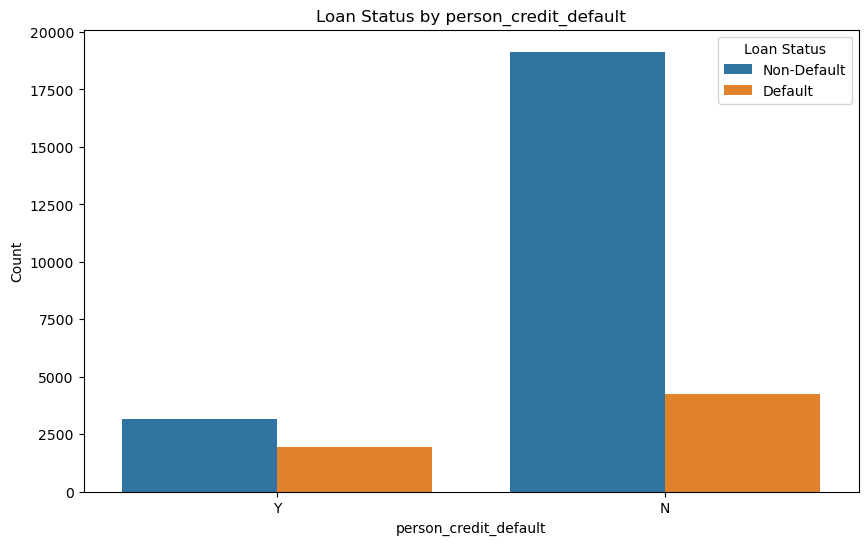

In [21]:


for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='loan_status', data=df)
    plt.title(f'Loan Status by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Loan Status', labels=['Non-Default', 'Default'])
    plt.show()

 

### Initial Model Attempt

Trying to fit this model resulted in a warning message due to reaching the maximum number of iterations, which can be attributed to the need for scaling the data to improve convergence and model performance.


In [24]:


# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'person_credit_default'],drop_first=True)
X = df_encoded.drop('loan_status', axis=1) 
y = df_encoded['loan_status']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced',random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.71      0.80      4436
           1       0.43      0.76      0.55      1264

    accuracy                           0.72      5700
   macro avg       0.67      0.73      0.67      5700
weighted avg       0.80      0.72      0.74      5700



c:\Users\Jimmy\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regression Analysis on Loan Status

This code performs logistic regression using statsmodels on a dataset that has been preprocessed with MinMaxScaler for feature scaling. Key insights from the summary are as follows:

- The model achieves a Pseudo R-squared value of 0.3584, indicating that it explains a significant portion of the variance in loan_status.
- Significant predictors influencing loan_status include loan_amnt, loan_percent_income, and loan_int_rate, supported by their low p-values (< 0.05) and substantial coefficients.
- Variables such as person_age, person_income, and person_emp_length also contribute to predicting loan_status, albeit with comparatively smaller effects relative to other predictors.
- Categorical features such as person_home_ownership and loan_intent exhibit varying impacts on loan_status across different categories, demonstrating statistically significant effects for certain categories.
- The logistic regression model exhibits robust performance based on the log-likelihood and LLR p-value (< 0.001), indicating its superiority over the null model.

These findings provide valuable insights into the factors influencing loan defaults and non-defaults, offering actionable intelligence for risk assessment and strategic decision-making in lending practices.

## Analysis of Variable Significance in Logistic Regression

Based on the logistic regression results, 'loan_percent_income' is the most significant variable and has the biggest effect on the loan status. This conclusion is drawn from the following observations:

- Coefficient Value: The coefficient for 'loan_percent_income' is 11.1340, which is substantially higher than the coefficients for other variables. This large positive coefficient indicates a strong relationship between 'loan_percent_income' and the likelihood of a loan being approved.
- Statistical Significance: The z-value for 'loan_percent_income' is 47.366, which is much higher than the typical threshold of 1.96 (for a 95% confidence level). The p-value is 0.000, indicating that the effect of 'loan_percent_income' on the loan status is highly statistically significant.
- Pseudo R-squared and Model Fit: The high z-value and low p-value, along with a substantial coefficient, suggest that 'loan_percent_income' plays a crucial role in explaining the variance in the dependent variable (loan status).

Among other variables, 'loan_amnt', 'loan_int_rate', and 'person_income' also have significant effects on loan status:

- 'loan_amnt': With a coefficient of -3.6438 and a p-value of 0.000, 'loan_amnt' is highly significant, indicating that higher loan amounts are associated with lower probabilities of loan approval.
- 'loan_int_rate': The coefficient for 'loan_int_rate' is 1.5946 with a p-value of 0.000, showing a strong positive effect on loan status.
- 'person_income': With a coefficient of 3.7574 and a p-value of 0.001, 'person_income' significantly impacts the likelihood of loan approval.

In summary, 'loan_percent_income' is the most significant variable influencing loan status because it has the highest coefficient value, indicating a strong positive effect, and it is statistically significant, contributing greatly to the model's predictive power. Other variables like 'loan_amnt', 'loan_int_rate', and 'person_income' also play crucial roles in predicting loan status.


In [25]:

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'person_credit_default'],drop_first=True)

# select the independant variables and the dependant variable
X = df_encoded.drop(['loan_status'], axis=1)
y = df_encoded['loan_status']

# Scale the independant variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) 
# print(X_scaled.head())
y = y.loc[X_scaled.index]

# Display statsmodels logistic regression on entire dataset to get a summary of 
X_scaled_sm = sm.add_constant(X_scaled)
model_sm = sm.Logit(y, X_scaled_sm)
result = model_sm.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.335683
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                28497
Model:                          Logit   Df Residuals:                    28474
Method:                           MLE   Df Model:                           22
Date:                Wed, 26 Jun 2024   Pseudo R-squ.:                  0.3585
Time:                        18:26:47   Log-Likelihood:                -9565.9
converged:                       True   LL-Null:                       -14912.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -3.9840      0.094    -42.504      0.000   

### Assessment of Variance Inflation Factor (VIF) 

- **'person_age'**: High VIF (56.911) suggests strong multicollinearity with other predictors, indicating that age might be closely correlated with other variables in the dataset.

- **'loan_int_rate'**: Very high VIF (70.741) indicates severe multicollinearity issues with other predictors, suggesting that loan_int_rate is strongly correlated with multiple variables in the dataset.


- Categorical variables such as **'person_credit_default'**, **'person_credit_history'**, **'person_home_ownership'**, **'loan_intent'**, and **'loan_grade'** show varying levels of collinearity, with VIF values generally indicating acceptable levels of multicollinearity.

Overall, high VIF values (greater than 10) for **'person_age'**, **'loan_int_rate'** indicate potential issues with multicollinearity that may affect the accuracy and interpretability of regression coefficients. Addressing multicollinearity through feature selection or regularization techniques could improve the reliability of the regression model.

**Note:** The high variance inflation factor (VIF) observed for loan_int_rate is probably due to the fact that interest rates are determined based on loan grades. This correlation suggests that including both variables in the model may lead to instability or redundancy in coefficient estimates.


In [26]:

# check multicollinearity among the predictors
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                        feature        VIF
0                    person_age  56.780140
1                 person_income   4.881297
2             person_emp_length   2.564231
3                     loan_amnt   8.852048
4                 loan_int_rate  70.737250
5           loan_percent_income   8.845834
6         person_credit_history  10.002607
7   person_home_ownership_OTHER   1.010580
8     person_home_ownership_OWN   1.238484
9    person_home_ownership_RENT   2.595983
10        loan_intent_EDUCATION   2.171792
11  loan_intent_HOMEIMPROVEMENT   1.695390
12          loan_intent_MEDICAL   2.115216
13         loan_intent_PERSONAL   2.026500
14          loan_intent_VENTURE   2.064559
15                 loan_grade_B   4.627394
16                 loan_grade_C   6.555488
17                 loan_grade_D   5.832862
18                 loan_grade_E   2.763052
19                 loan_grade_F   1.557203
20                 loan_grade_G   1.206849
21      person_credit_default_Y   2.026817


### Identifying Multicollinearity
Based on the analysis below of the correlation matrix, it is confirmed that **'loan_int_rate'** is highly correlated with **'loan_grade'**, which explains the very high VIF (70.741) observed for **'loan_int_rate'**. This indicates that **'loan_int_rate'** shares a strong relationship with **'loan_grade'** and potentially other variables. Similarly, **'person_age'** exhibits a high VIF (56.911), which can be attributed to its strong correlation with **'person_credit_history'**. These findings from the correlation matrix reinforce the multicollinearity issues identified through the VIF analysis, highlighting the close relationships between these specific pairs of features in the dataset.

In this scenario, it suggests that either **'loan_int_rate'** or **'loan_grade'**, as well as **'person_age'** or **'person_credit_history'**, could be removed from the model without significantly impacting its performance. This understanding is crucial for simplifying the model and reducing redundancy in feature representation.



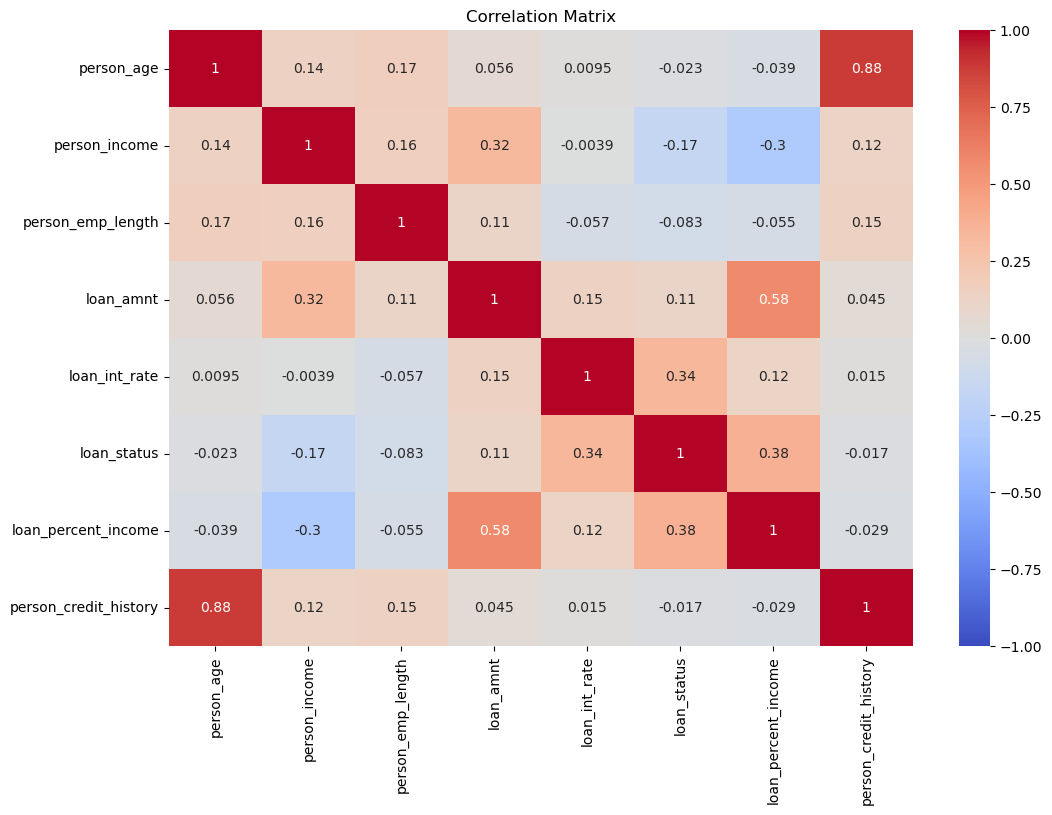

In [27]:
# Correlation Matrix
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade'])
plt.figure(figsize=(12, 8))
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


## Analysis: Comparing Unbalanced vs. Balanced Models

### Unbalanced Model vs. Balanced Model

#### Unbalanced Model Results:
The unbalanced model shows an overall accuracy of 87%. It achieves a precision of 0.77 and recall of 0.55 for default cases, with an F1-score of 0.64.

#### Balanced Model Results:
In contrast, the balanced model exhibits an accuracy of 82%. It has a precision of 0.56 and notably higher recall of 0.79 for default cases, resulting in an improved F1-score of 0.66.

### Insights and Conclusion

#### Understanding the Trade-offs:
The decision to move from an unbalanced to a balanced approach was driven by the need to enhance the model's ability to detect loan default cases accurately. While the overall accuracy slightly decreased, the balanced model significantly improved its recall for default cases.

#### Business Implications:
In the context of loan risk assessment, identifying potential defaulters (true positives) is crucial for minimizing financial losses. The balanced model’s higher recall ensures that fewer default cases are missed, aligning more closely with the business goal of risk mitigation.

Choosing the balanced model, despite the modest drop in overall accuracy, is justified by its stronger performance in capturing default instances. This approach provides lenders with more reliable insights, enabling proactive measures to manage loan portfolios effectively.


              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4436
           1       0.77      0.56      0.65      1264

    accuracy                           0.87      5700
   macro avg       0.83      0.76      0.78      5700
weighted avg       0.86      0.87      0.86      5700

Training Accuracy: 0.87
Test Accuracy: 0.87


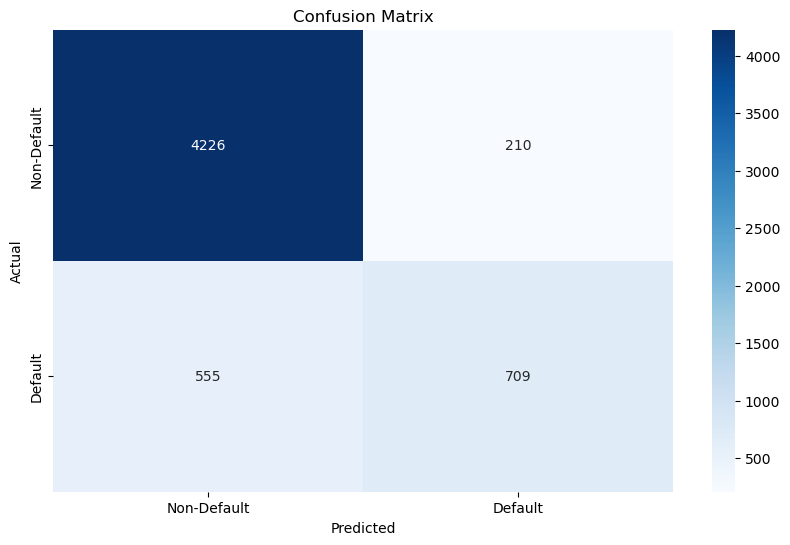

Confusion Matrix:

True Negatives: 4226
False Positives: 210
False Negatives: 555
True Positives: 709


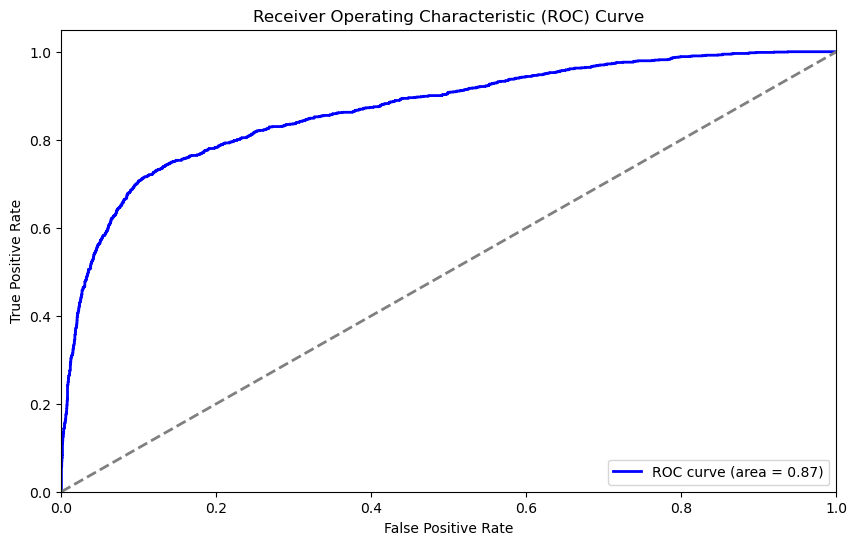

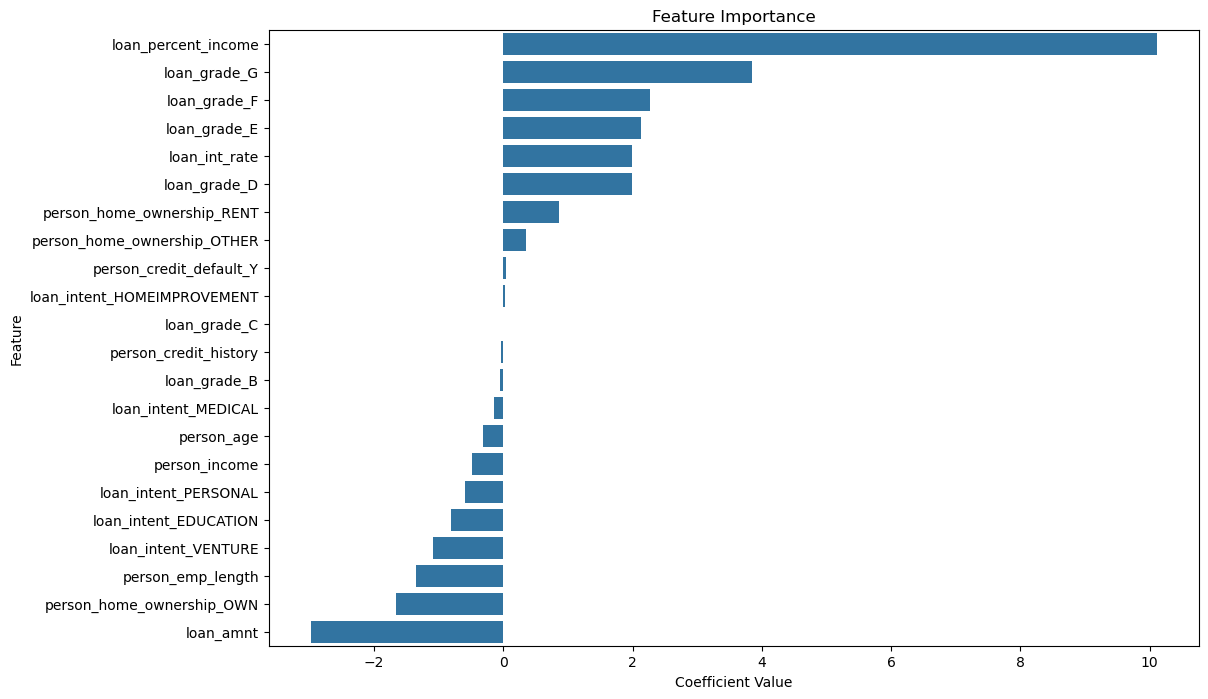

In [31]:
# Unbalanced Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model on training data
model = LogisticRegression( random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Calculate accuracy scores for training and test sets
train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Extract values
tn, fp, fn, tp = cm.ravel()

# Print values in a readable format
print(f"Confusion Matrix:\n")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
# ROC Curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4436
           1       0.56      0.77      0.65      1264

    accuracy                           0.81      5700
   macro avg       0.74      0.80      0.76      5700
weighted avg       0.84      0.81      0.82      5700

Training Accuracy: 0.81
Test Accuracy: 0.81


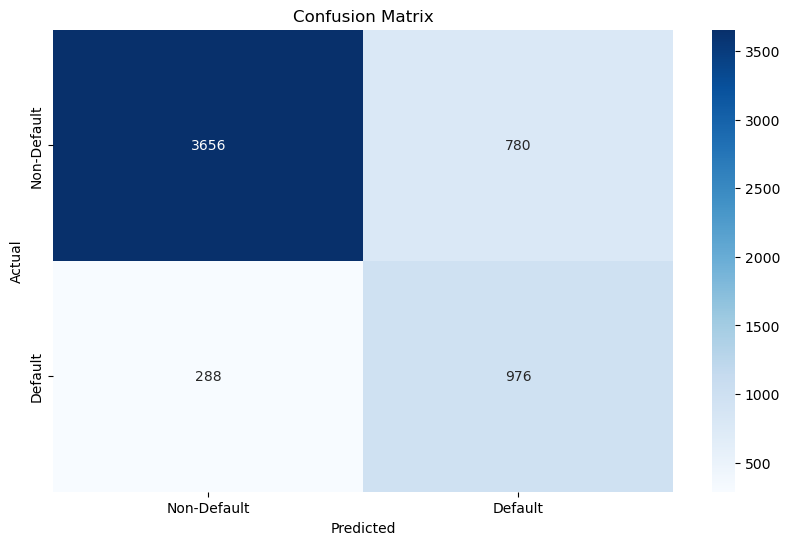

Confusion Matrix:

True Negatives: 3656
False Positives: 780
False Negatives: 288
True Positives: 976


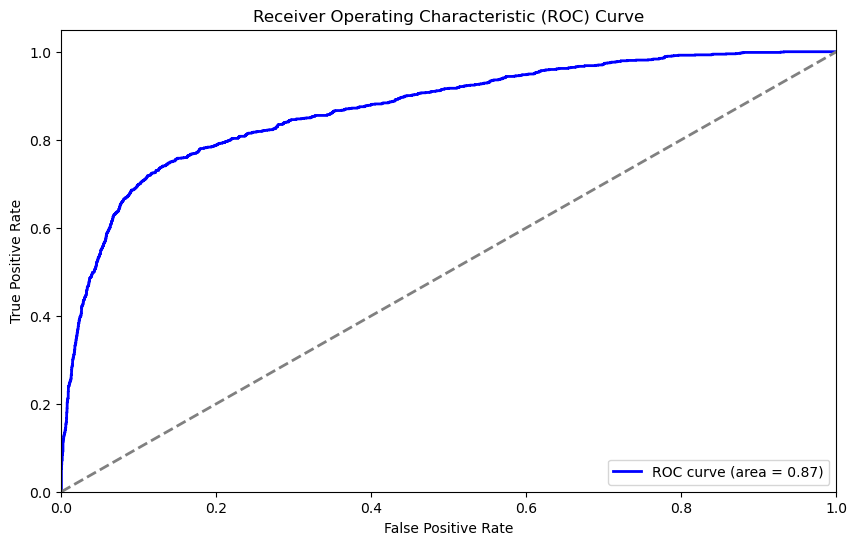

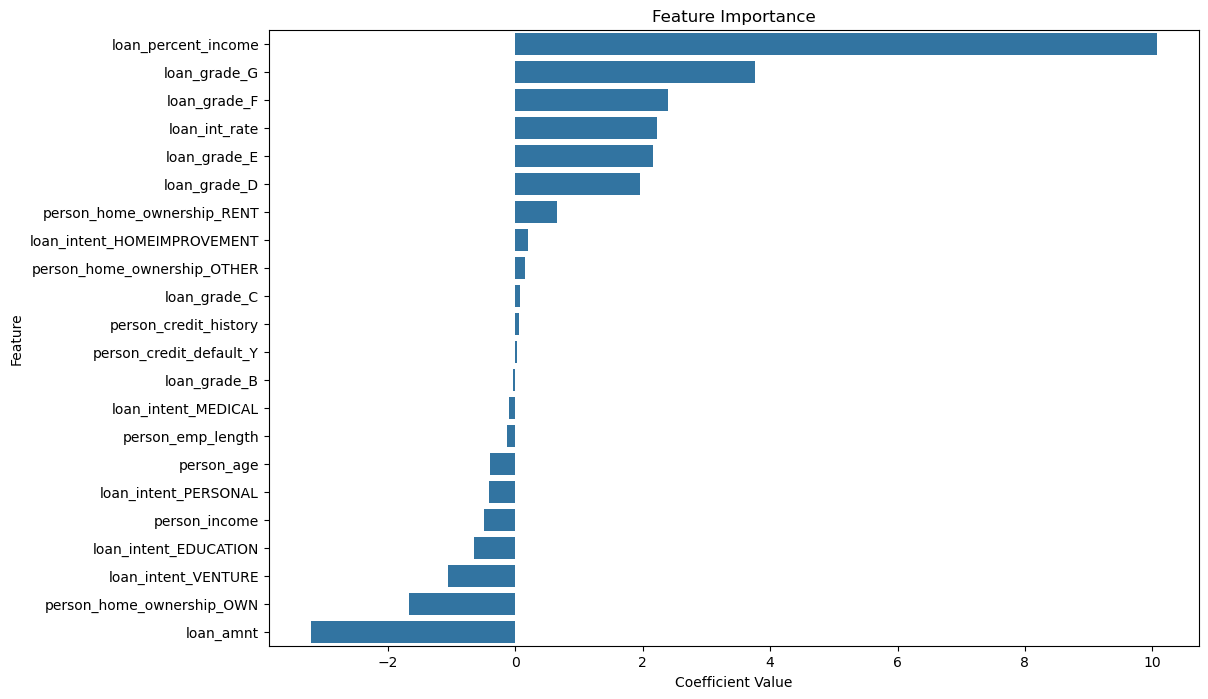

In [29]:
# Balanced Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Fit logistic regression model on training data
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Calculate accuracy scores for training and test sets
train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Extract values
tn, fp, fn, tp = cm.ravel()

# Print values in a readable format
print(f"Confusion Matrix:\n")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
# ROC Curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()